# Election Simulation Analysis

This notebook analyzes the results of the election simulation.


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from utils import get_data, calculate_similarity

# type_data = "all_data"
# type_data = "same_seed"
type_data = "different_seed"

data = get_data(type_data)

In [45]:
sim_data = data[0]

In [46]:
# all data is from one simulation
def get_voter_agents(data):
    people = {}
    for person in data["people_agents"]:
        people[person["name"]] = person

    return people


def get_voter_names(data):
    people = get_voter_agents(data)
    return [person["name"] for person in people.values()]


def get_candidate_agents(data):
    candidates = {}
    for candidate in data["candidate_agents"]:
        candidates[candidate["name"]] = candidate

    return candidates


def get_candidate_names(data, include_abstain=False):
    candidates = get_candidate_agents(data)
    candidate_names = [candidate["name"] for candidate in candidates.values()]
    if include_abstain:
        return candidate_names + ["ABSTAIN"]
    else:
        return candidate_names


def get_all_agents(data):
    people = get_voter_agents(data)
    candidates = get_candidate_agents(data)

    agents = {**people, **candidates}

    return agents


def get_vote_history(data):
    return data.get("who_voted_for_who_history", [])

In [48]:
def plot_voter_candidate_similarity_over_time(data):
    """Plot the similarity between voters and their chosen candidates over time, grouped by model type."""
    history = get_vote_history(data)
    voter_agents = get_voter_agents(data)
    candidate_agents = get_candidate_agents(data)

    num_days = len(history)
    days = list(range(1, num_days + 1))

    colors = [
        "#d6604d",
        "#4393c3",
        "#5aae61",
        "#8073ac",
        "#de77ae",
        "#fee090",
        "#bf812d",
        "#878787",
    ]

    model_voters = {}
    for voter_name, voter_profile in voter_agents.items():
        model_name = voter_profile.get("model_name", "Unknown")
        if model_name not in model_voters:
            model_voters[model_name] = []
        model_voters[model_name].append(voter_name)

    model_similarities = {}

    for model_name, voters_in_model in model_voters.items():
        model_similarities[model_name] = []

        for day_idx in range(num_days):
            day_votes = history[day_idx]
            day_similarities = []

            for voter_name in voters_in_model:
                if voter_name in day_votes:
                    chosen_candidate = day_votes[voter_name]

                    if (
                        chosen_candidate == "ABSTAIN"
                        or chosen_candidate not in candidate_agents
                    ):
                        similarity = 0
                    else:
                        voter_profile = voter_agents[voter_name]
                        candidate_profile = candidate_agents[chosen_candidate]
                        similarity = calculate_similarity(
                            voter_profile, candidate_profile
                        )
                else:
                    similarity = 0

                day_similarities.append(similarity)

            if day_similarities:
                model_similarities[model_name].append(np.mean(day_similarities))
            else:
                model_similarities[model_name].append(0)

    plt.figure(figsize=(16, 10))

    model_avg_similarities = {
        model_name: np.mean(similarities)
        for model_name, similarities in model_similarities.items()
    }
    sorted_models = sorted(model_avg_similarities.items(), key=lambda x: x[1])

    for i, (model_name, avg_sim) in enumerate(sorted_models):
        similarities = model_similarities[model_name]
        plt.plot(
            days,
            similarities,
            marker="o",
            linewidth=3,
            markersize=7,
            label=f"{model_name} (avg of {len(model_voters[model_name])} voters)",
            alpha=0.9,
            color=colors[i % len(colors)],
        )

    overall_avg_similarities = []
    for day_idx in range(num_days):
        all_day_similarities = []
        for model_similarities_list in model_similarities.values():
            all_day_similarities.append(model_similarities_list[day_idx])
        overall_avg_similarities.append(np.mean(all_day_similarities))

    plt.plot(
        days,
        overall_avg_similarities,
        color="black",
        linewidth=4,
        label="Overall Average Similarity",
        linestyle="--",
        marker="s",
        markersize=8,
        alpha=0.8,
    )

    plt.axhline(y=0, color="gray", linestyle=":", alpha=0.7, linewidth=2)

    plt.xlabel("Day", fontsize=16, fontweight="bold")
    plt.ylabel("Voter-Candidate Similarity", fontsize=16, fontweight="bold")
    plt.title(
        "Voter-Candidate Similarity Over Time by Model Type\n(Red = Negative Similarity, Blue = Positive Similarity)",
        fontsize=18,
        fontweight="bold",
        pad=20,
    )
    plt.grid(True, alpha=0.3, linewidth=1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)
    plt.ylim(-1.05, 1.05)
    plt.xticks(days, fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

    return model_similarities, overall_avg_similarities

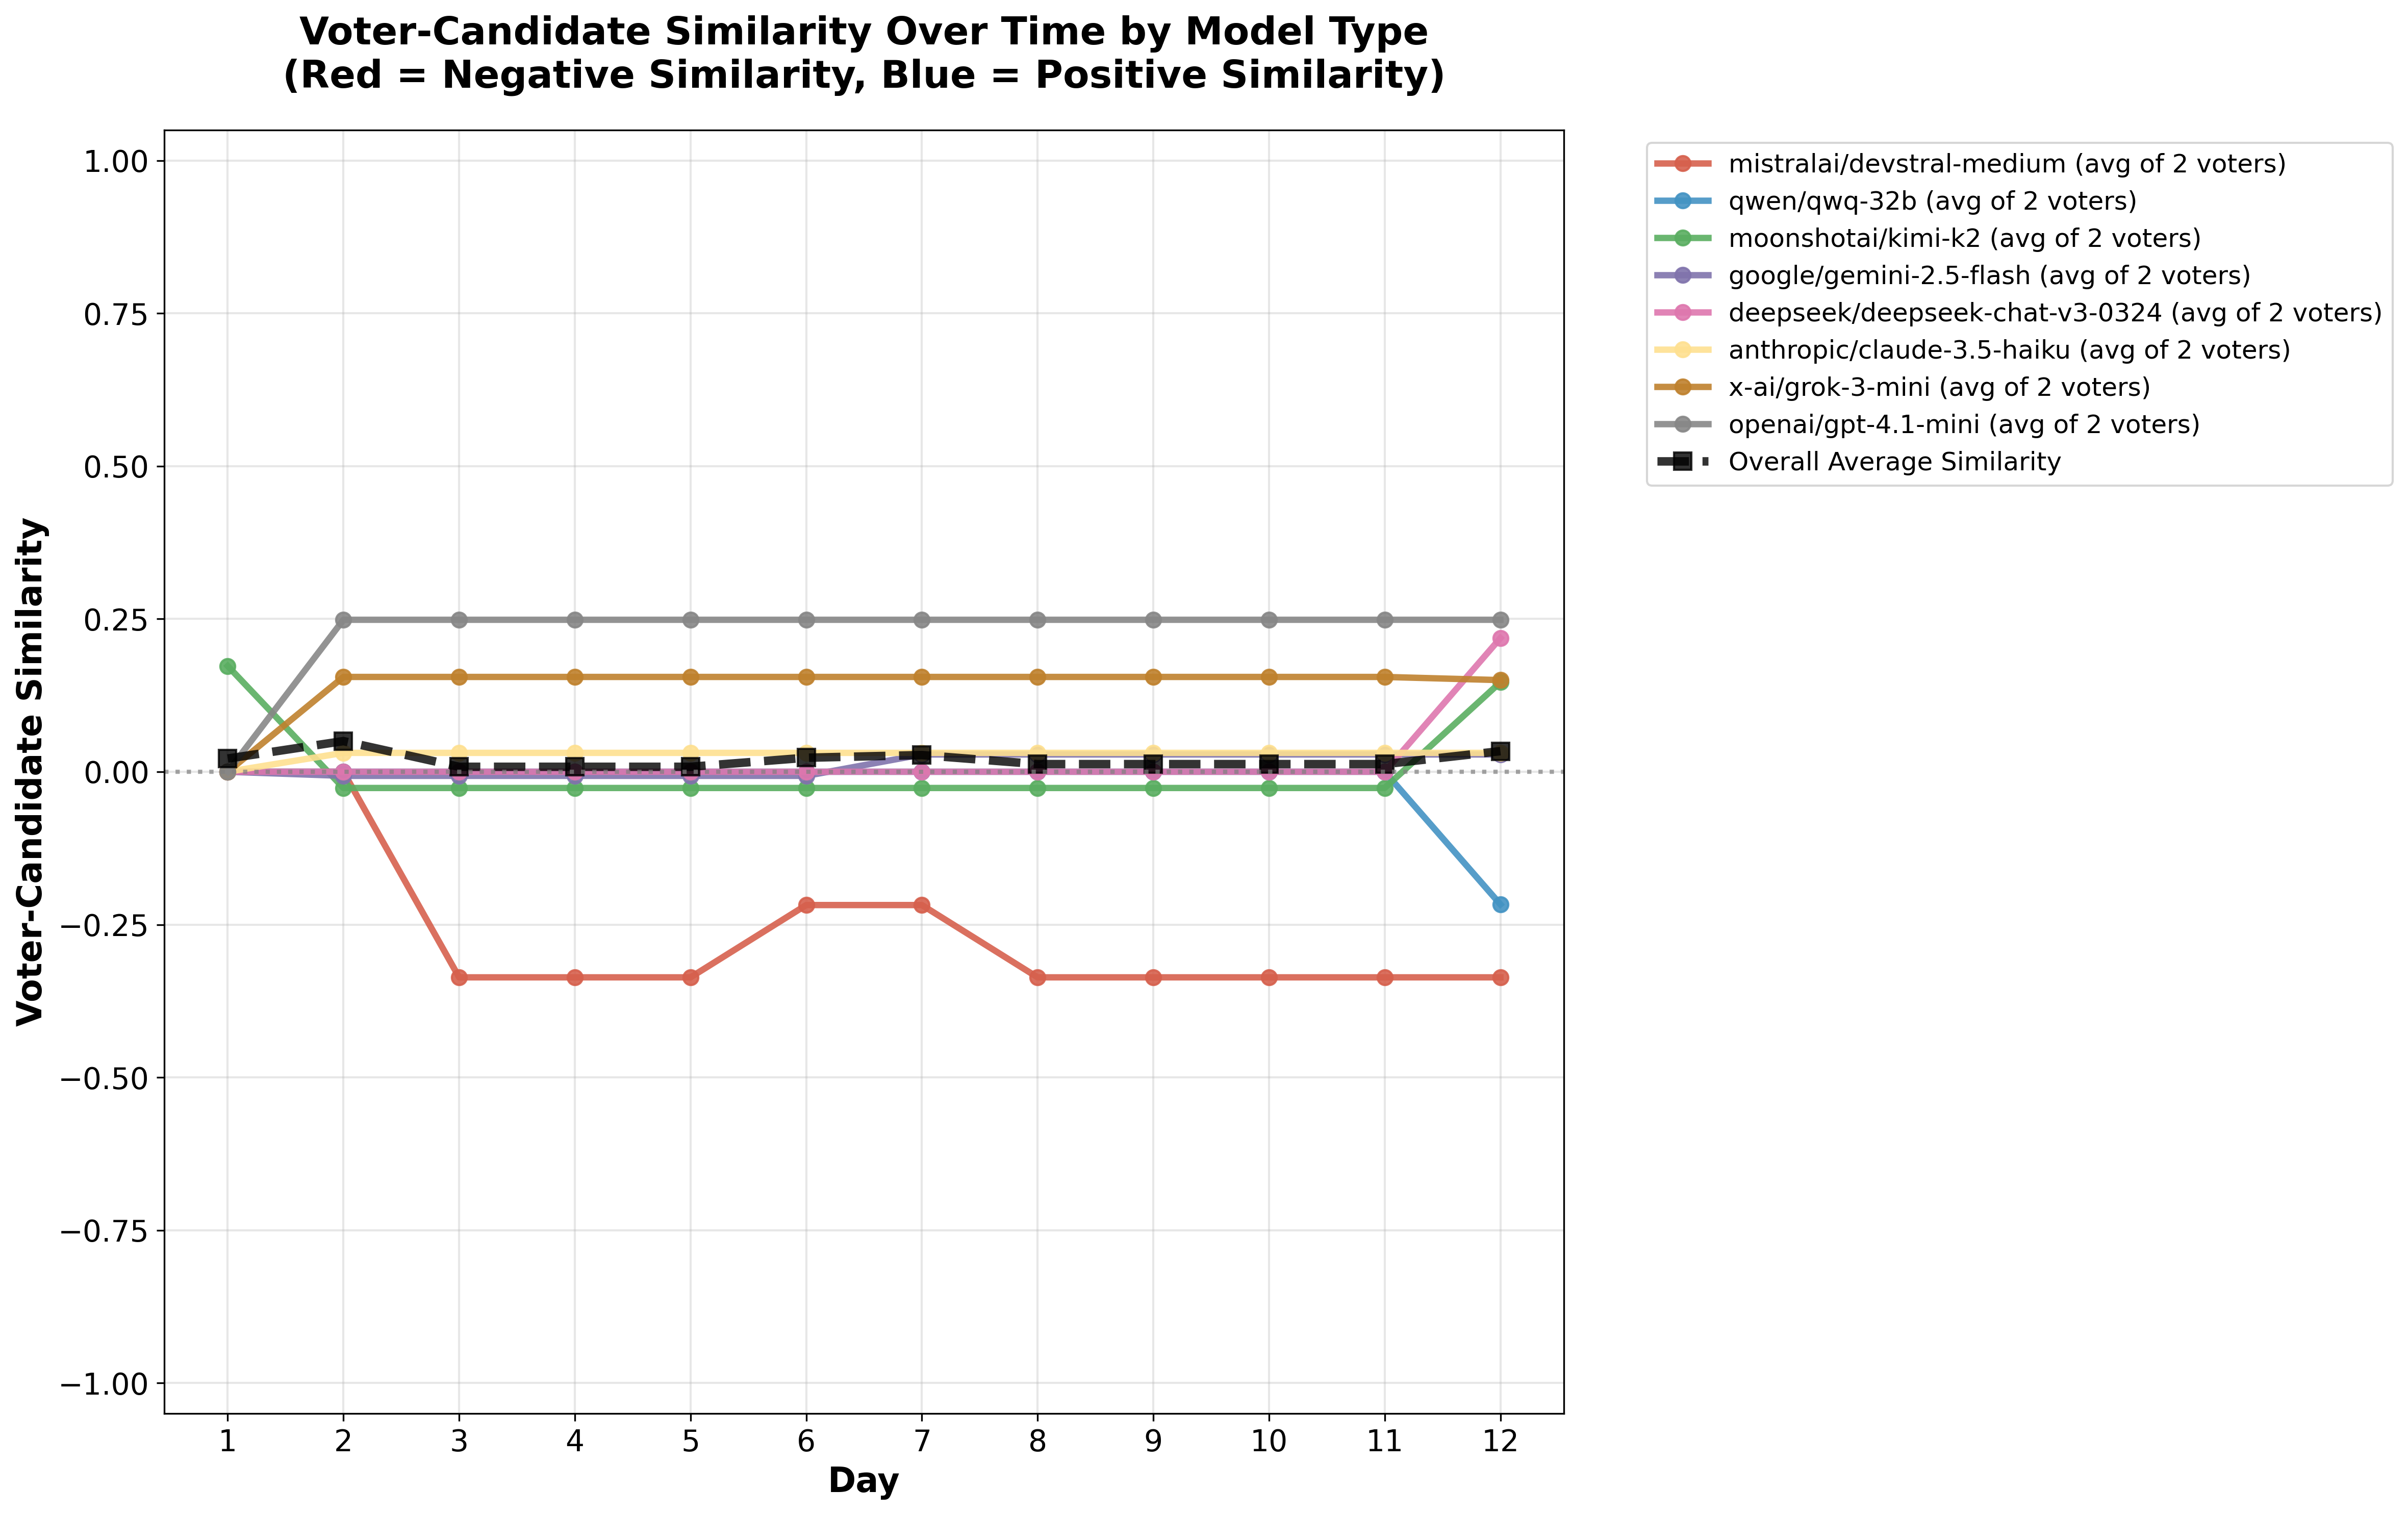

Average similarity by day (overall):
Day 1: 0.022
Day 2: 0.050
Day 3: 0.008
Day 4: 0.008
Day 5: 0.008
Day 6: 0.023
Day 7: 0.027
Day 8: 0.013
Day 9: 0.013
Day 10: 0.013
Day 11: 0.013
Day 12: 0.034

Average similarity by model type:
openai/gpt-4.1-mini: 0.228
google/gemini-2.5-flash: 0.011
anthropic/claude-3.5-haiku: 0.028
deepseek/deepseek-chat-v3-0324: 0.018
qwen/qwq-32b: -0.018
x-ai/grok-3-mini: 0.142
moonshotai/kimi-k2: 0.004
mistralai/devstral-medium: -0.261


In [49]:
model_similarities, overall_avg_similarities = (
    plot_voter_candidate_similarity_over_time(sim_data)
)

print("Average similarity by day (overall):")
for i, avg_sim in enumerate(overall_avg_similarities):
    print(f"Day {i+1}: {avg_sim:.3f}")

print("\nAverage similarity by model type:")
for model_name, similarities in model_similarities.items():
    avg_for_model = np.mean(similarities)
    print(f"{model_name}: {avg_for_model:.3f}")

In [50]:
def plot_candidate_voter_similarity_with_baseline(data):
    """Plot the average similarity between each candidate and their voters over time with baseline comparisons."""
    history = get_vote_history(data)
    all_agents = get_all_agents(data)
    candidate_agents = get_candidate_agents(data)
    candidate_names = get_candidate_names(data, include_abstain=False)
    voter_agents = get_voter_agents(data)

    num_days = len(history)
    days = list(range(1, num_days + 1))

    colors = [
        "#d6604d",
        "#4393c3",
    ]

    candidate_similarities = {name: [] for name in candidate_names}

    candidate_vote_counts = {name: [] for name in candidate_names}

    for day_idx in range(num_days):
        day_votes = history[day_idx]
        day_candidate_sims = {name: [] for name in candidate_names}
        day_vote_counts = {name: 0 for name in candidate_names}

        for voter_name, chosen_candidate in day_votes.items():
            if voter_name in voter_agents and chosen_candidate in candidate_names:
                day_vote_counts[chosen_candidate] += 1

                voter_profile = all_agents[voter_name]
                chosen_candidate_profile = candidate_agents[chosen_candidate]

                similarity = calculate_similarity(
                    voter_profile, chosen_candidate_profile
                )
                day_candidate_sims[chosen_candidate].append(similarity)

        for name in candidate_names:
            candidate_vote_counts[name].append(day_vote_counts[name])

        for name in candidate_names:
            if day_candidate_sims[name]:
                avg_sim = np.mean(day_candidate_sims[name])
                candidate_similarities[name].append(avg_sim)
            else:
                candidate_similarities[name].append(0)

    fig, ax1 = plt.subplots(figsize=(16, 10))

    ax2 = ax1.twinx()

    candidate_avg_similarities = {
        name: np.mean(similarities)
        for name, similarities in candidate_similarities.items()
    }
    sorted_candidates = sorted(candidate_avg_similarities.items(), key=lambda x: x[1])

    for i, (name, avg_sim) in enumerate(sorted_candidates):
        color_index = 0 if avg_sim < 0 else 1
        if len(sorted_candidates) > 2:
            color_index = i

        ax1.plot(
            days,
            candidate_similarities[name],
            marker="o",
            linewidth=4,
            markersize=8,
            label=f"{candidate_agents[name]['model_name']} ({name}) - Similarity",
            color=colors[color_index % len(colors)],
            alpha=0.9,
        )

        ax2.plot(
            days,
            candidate_vote_counts[name],
            marker="^",
            linewidth=2.5,
            markersize=7,
            linestyle="--",
            alpha=0.8,
            color=colors[color_index % len(colors)],
            markerfacecolor="white",
            markeredgecolor=colors[color_index % len(colors)],
            markeredgewidth=2,
            label=f"{candidate_agents[name]['model_name']} ({name}) - Votes",
        )

    ax1.axhline(y=0, color="gray", linestyle=":", alpha=0.7, linewidth=2)

    ax1.set_xlabel("Day", fontsize=16, fontweight="bold")
    ax1.set_ylabel("Voter-Candidate Similarity", fontsize=16, fontweight="bold")
    ax2.set_ylabel("Number of Votes", fontsize=16, fontweight="bold", color="black")

    ax1.set_title(
        "Average Similarity Between Candidates and Their Voters Over Time\n(Red = Negative Similarity, Blue = Positive Similarity)",
        fontsize=18,
        fontweight="bold",
        pad=20,
    )

    ax1.grid(True, alpha=0.3, linewidth=1)
    ax1.set_ylim(-1.05, 1.05)
    ax1.set_xticks(days)
    ax1.tick_params(axis="both", which="major", labelsize=14)

    max_votes = max([max(counts) for counts in candidate_vote_counts.values()] + [1])
    ax2.set_ylim(0, max_votes * 1.1)
    ax2.tick_params(axis="y", labelcolor="black", labelsize=14)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
        lines1 + lines2,
        labels1 + labels2,
        fontsize=11,
        bbox_to_anchor=(1.15, 1),
        loc="upper left",
    )

    plt.tight_layout()
    plt.show()

    return (
        candidate_similarities,
        candidate_vote_counts,
    )

Testing the corrected function with agent names:


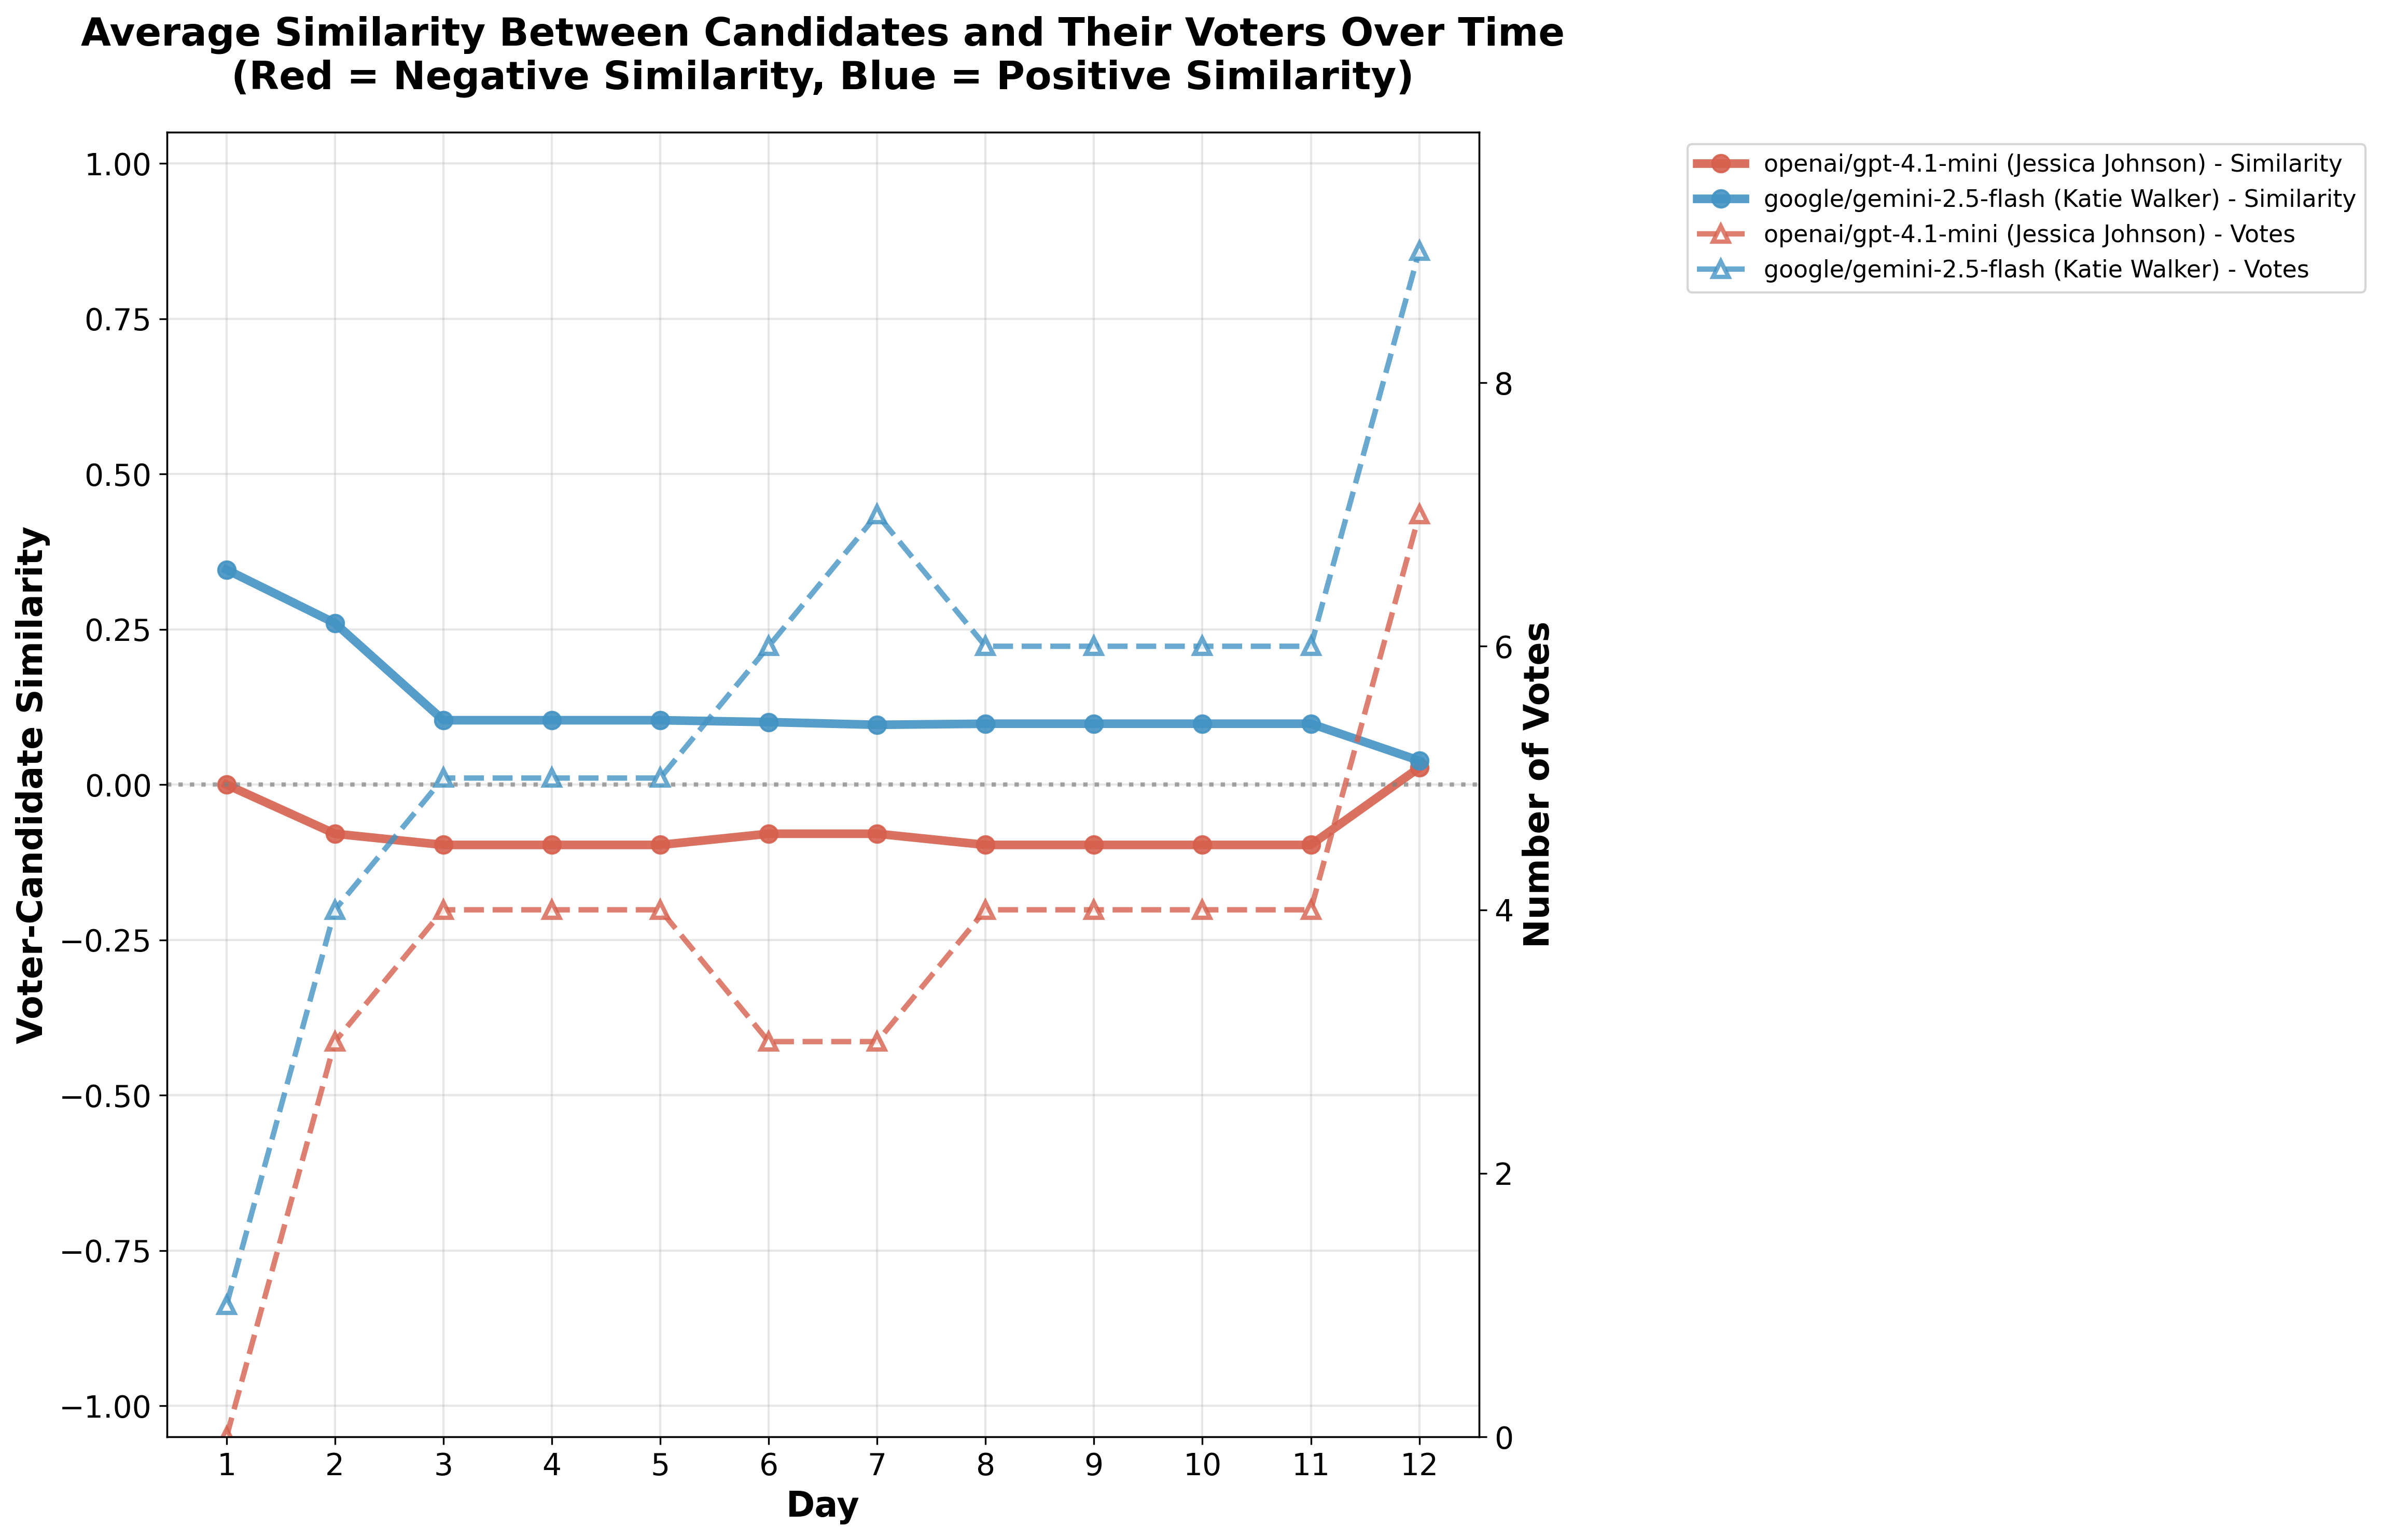


✅ Function executed successfully!
Candidates found: ['Katie Walker', 'Jessica Johnson']
Number of days: 12

Vote count statistics:
Katie Walker: 66 total votes, 5.5 avg per day
Jessica Johnson: 44 total votes, 3.7 avg per day


In [51]:
print("Testing the corrected function with agent names:")
candidate_sims, vote_counts = plot_candidate_voter_similarity_with_baseline(sim_data)
candidate_names = get_candidate_names(sim_data, include_abstain=False)
print(f"\n✅ Function executed successfully!")
print(f"Candidates found: {candidate_names}")
print(f"Number of days: {len(vote_counts[candidate_names[0]])}")

print(f"\nVote count statistics:")
for candidate in candidate_names:
    total_votes = sum(vote_counts[candidate])
    avg_votes_per_day = np.mean(vote_counts[candidate])
    print(
        f"{candidate}: {total_votes} total votes, {avg_votes_per_day:.1f} avg per day"
    )

In [52]:
def plot_candidate_similarity_boxplots(data):
    """Create side-by-side box plots showing the distribution of voter similarity scores for each candidate over time."""
    history = get_vote_history(data)
    all_agents = get_all_agents(data)
    candidate_agents = get_candidate_agents(data)
    candidate_names = get_candidate_names(data, include_abstain=False)
    voter_agents = get_voter_agents(data)  # Get only actual voters

    num_days = len(history)

    colors = [
        "#d6604d",
        "#4393c3",
        "#5aae61",
        "#8073ac",
        "#de77ae",
        "#fee090",
        "#bf812d",
        "#878787",
    ]

    plot_data = []

    for day_idx in range(num_days):
        day = day_idx + 1
        day_votes = history[day_idx]

        for candidate_name in candidate_names:
            voter_similarities = []

            for voter_name, chosen_candidate in day_votes.items():
                if voter_name in voter_agents and chosen_candidate == candidate_name:
                    voter_profile = all_agents[voter_name]
                    candidate_profile = candidate_agents[candidate_name]
                    similarity = calculate_similarity(voter_profile, candidate_profile)
                    voter_similarities.append(similarity)

            for similarity in voter_similarities:
                plot_data.append(
                    {
                        "Day": day,
                        "Candidate": f"{candidate_agents[candidate_name]['model_name']} ({candidate_name})",
                        "SimilarityScore": similarity,
                    }
                )

    df = pd.DataFrame(plot_data)

    all_models = set()
    for candidate_name in candidate_names:
        model_name = candidate_agents[candidate_name].get("model_name", "Unknown")
        all_models.add(model_name)

    sorted_models = sorted(all_models)
    model_color_map = {
        model: colors[i % len(colors)] for i, model in enumerate(sorted_models)
    }

    palette = {}
    for candidate_name in candidate_names:
        candidate_label = (
            f"{candidate_agents[candidate_name]['model_name']} ({candidate_name})"
        )
        model_name = candidate_agents[candidate_name].get("model_name", "Unknown")
        palette[candidate_label] = model_color_map[model_name]

    plt.figure(figsize=(16, 10))

    ax = sns.boxplot(
        data=df,
        x="Day",
        y="SimilarityScore",
        hue="Candidate",
        palette=palette,
        showfliers=True,
        width=0.6,
        linewidth=2,
    )

    plt.axhline(y=0, color="gray", linestyle=":", alpha=0.7, linewidth=2)

    plt.title(
        "Distribution of Voter-Candidate Similarity Scores Over Time\n(Colors Based on Model Type)",
        fontsize=18,
        fontweight="bold",
        pad=20,
    )
    plt.xlabel("Day", fontsize=16, fontweight="bold")
    plt.ylabel("Voter-Candidate Similarity Score", fontsize=16, fontweight="bold")
    plt.ylim(-1.05, 1.05)

    plt.legend(
        title="Model",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=12,
        title_fontsize=14,
        framealpha=0.9,
    )

    plt.grid(True, alpha=0.3, axis="y", linewidth=1)

    # Customize tick labels
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if num_days > 10:
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("Summary Statistics by Day and Candidate:")
    print("=" * 50)

    for day in sorted(df["Day"].unique()):
        print(f"\nDay {day}:")
        day_data = df[df["Day"] == day]

        for candidate in candidate_names:
            candidate_label = (
                f"{candidate_agents[candidate]['model_name']} ({candidate})"
            )
            candidate_data = day_data[day_data["Candidate"] == candidate_label][
                "SimilarityScore"
            ]

            voters_for_candidate = [
                voter_name
                for voter_name, chosen_candidate in history[day - 1].items()
                if voter_name in voter_agents and chosen_candidate == candidate
            ]

            if len(candidate_data) > 0:
                print(f"  {candidate_label}:")
                print(f"    Count: {len(candidate_data)}")
                print(f"    Mean: {candidate_data.mean():.3f}")
                print(f"    Median: {candidate_data.median():.3f}")
                print(f"    Std Dev: {candidate_data.std():.3f}")
                print(f"    Min: {candidate_data.min():.3f}")
                print(f"    Max: {candidate_data.max():.3f}")
                if voters_for_candidate:
                    print(f"    Voters (by model):")
                    for voter in voters_for_candidate:
                        model = (
                            all_agents[voter]["model_name"]
                            if voter in all_agents
                            else "Unknown"
                        )
                        print(f"      - {model}")
                else:
                    print(f"    Voters: None")
            else:
                print(f"  {candidate_label}: No votes")

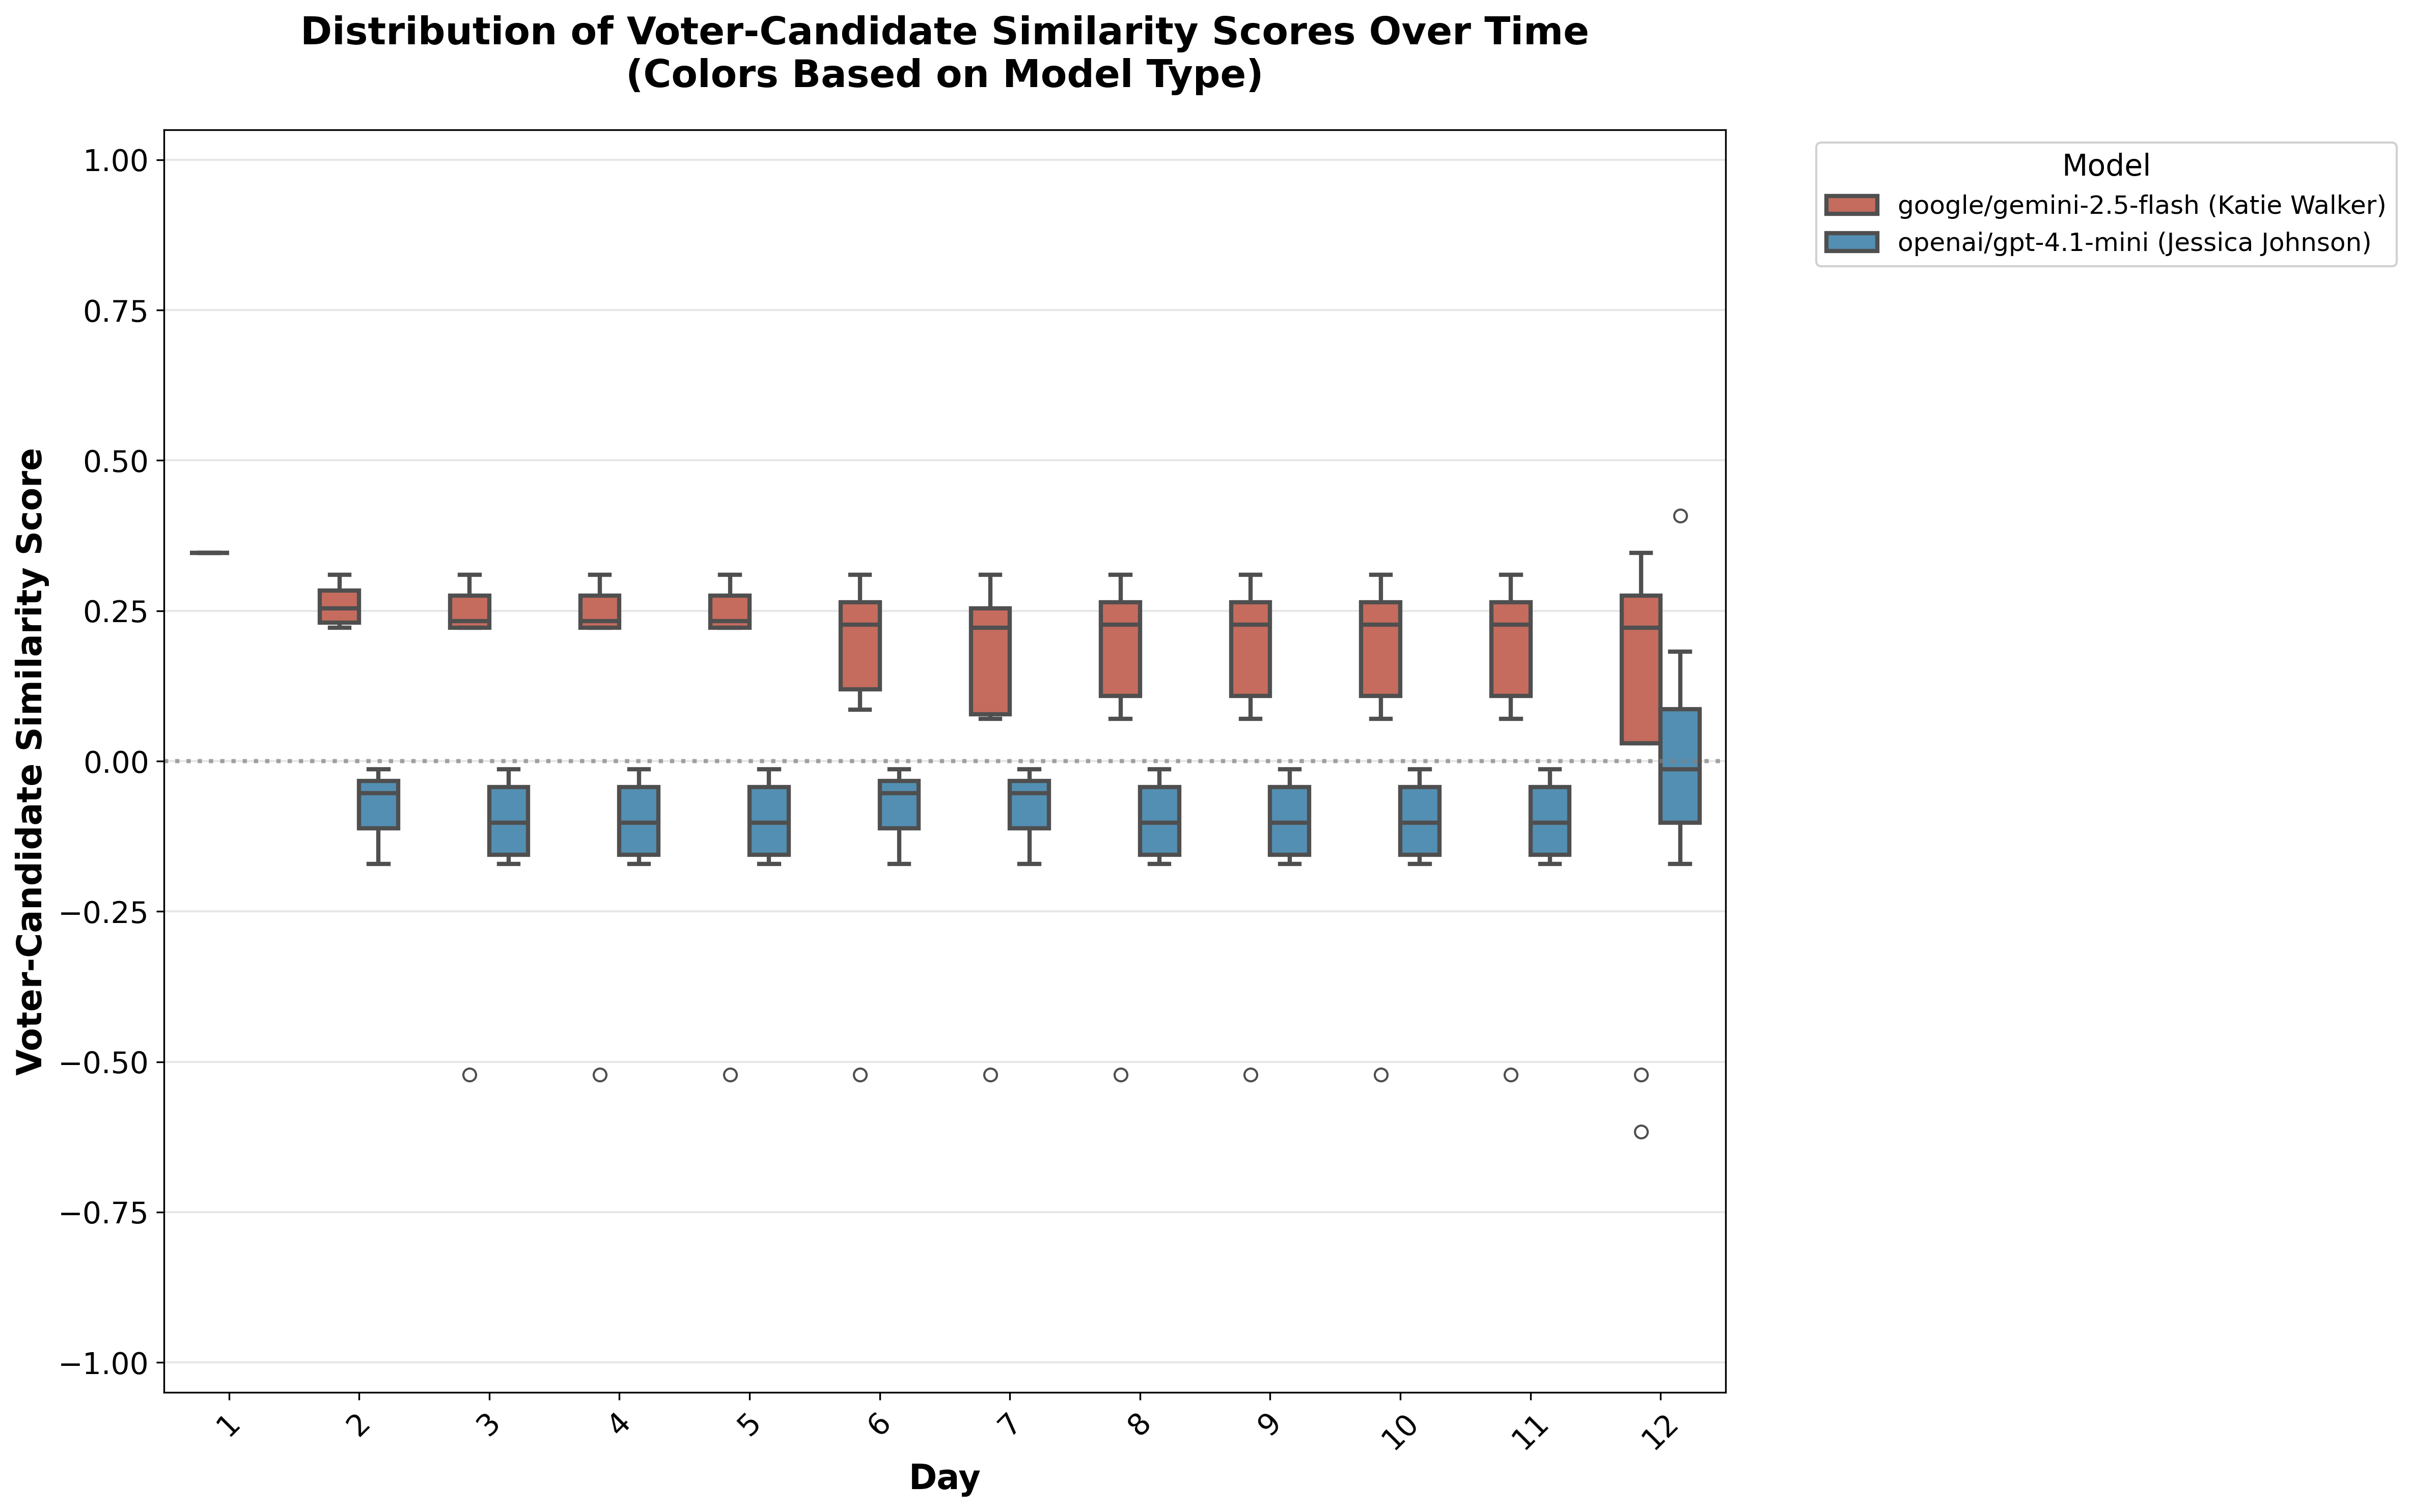

Summary Statistics by Day and Candidate:

Day 1:
  google/gemini-2.5-flash (Katie Walker):
    Count: 1
    Mean: 0.346
    Median: 0.346
    Std Dev: nan
    Min: 0.346
    Max: 0.346
    Voters (by model):
      - moonshotai/kimi-k2
  openai/gpt-4.1-mini (Jessica Johnson): No votes

Day 2:
  google/gemini-2.5-flash (Katie Walker):
    Count: 4
    Mean: 0.260
    Median: 0.254
    Std Dev: 0.041
    Min: 0.222
    Max: 0.310
    Voters (by model):
      - openai/gpt-4.1-mini
      - openai/gpt-4.1-mini
      - anthropic/claude-3.5-haiku
      - x-ai/grok-3-mini
  openai/gpt-4.1-mini (Jessica Johnson):
    Count: 3
    Mean: -0.079
    Median: -0.053
    Std Dev: 0.082
    Min: -0.171
    Max: -0.013
    Voters (by model):
      - google/gemini-2.5-flash
      - anthropic/claude-3.5-haiku
      - moonshotai/kimi-k2

Day 3:
  google/gemini-2.5-flash (Katie Walker):
    Count: 5
    Mean: 0.104
    Median: 0.233
    Std Dev: 0.351
    Min: -0.522
    Max: 0.310
    Voters (by model):
  

In [53]:
plot_candidate_similarity_boxplots(sim_data)

In [54]:
def plot_all_simulations_voter_candidate_similarity(all_data, type_data=None):
    """Plot voter-candidate similarity over time for all simulations grouped by model type."""

    num_sims = len(all_data)
    if num_sims == 5:
        rows, cols = 2, 3
        figsize = (30, 16)
    elif num_sims == 6:
        rows, cols = 3, 2
        figsize = (30, 16)
    elif num_sims == 10:
        rows, cols = 5, 2
        figsize = (20, 50)
    else:
        rows, cols = 2, 3
        figsize = (30, 16)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    colors = [
        "#d6604d",
        "#4393c3",
        "#5aae61",
        "#8073ac",
        "#de77ae",
        "#fee090",
        "#bf812d",
        "#878787",
    ]

    all_models = set()
    for sim_data in all_data:
        voter_agents = get_voter_agents(sim_data)
        for voter_profile in voter_agents.values():
            model_name = voter_profile.get("model_name", "Unknown")
            all_models.add(model_name)
        candidate_agents = get_candidate_agents(sim_data)
        for candidate_profile in candidate_agents.values():
            model_name = candidate_profile.get("model_name", "Unknown")
            all_models.add(model_name)

    sorted_all_models = sorted(all_models)
    model_color_map = {
        model: colors[i % len(colors)] for i, model in enumerate(sorted_all_models)
    }
    model_color_map["Overall Average Similarity"] = "black"

    for sim_idx, sim_data in enumerate(all_data):
        ax = axes[sim_idx]

        history = get_vote_history(sim_data)
        voter_agents = get_voter_agents(sim_data)
        candidate_agents = get_candidate_agents(sim_data)

        num_days = len(history)
        days = list(range(1, num_days + 1))

        model_voters = {}
        for voter_name, voter_profile in voter_agents.items():
            model_name = voter_profile.get("model_name", "Unknown")
            if model_name not in model_voters:
                model_voters[model_name] = []
            model_voters[model_name].append(voter_name)

        model_similarities = {}

        for model_name, voters_in_model in model_voters.items():
            model_similarities[model_name] = []

            for day_idx in range(num_days):
                day_votes = history[day_idx]
                day_similarities = []

                for voter_name in voters_in_model:
                    if voter_name in day_votes:
                        chosen_candidate = day_votes[voter_name]

                        if (
                            chosen_candidate == "ABSTAIN"
                            or chosen_candidate not in candidate_agents
                        ):
                            similarity = 0
                        else:
                            voter_profile = voter_agents[voter_name]
                            candidate_profile = candidate_agents[chosen_candidate]
                            similarity = calculate_similarity(
                                voter_profile, candidate_profile
                            )
                    else:
                        similarity = 0

                    day_similarities.append(similarity)

                if day_similarities:
                    model_similarities[model_name].append(np.mean(day_similarities))
                else:
                    model_similarities[model_name].append(0)

        # Plot each model's average similarity over time using consistent colors
        for model_name in sorted_all_models:
            if model_name in model_similarities:
                similarities = model_similarities[model_name]
                ax.plot(
                    days,
                    similarities,
                    marker="o",
                    linewidth=3,
                    markersize=6,
                    label=f"{model_name} (avg of {len(model_voters[model_name])} voters)",
                    alpha=0.9,
                    color=model_color_map[model_name],
                )

        # Calculate and plot overall average similarity
        overall_avg_similarities = []
        for day_idx in range(num_days):
            all_day_similarities = []
            for model_similarities_list in model_similarities.values():
                all_day_similarities.append(model_similarities_list[day_idx])
            overall_avg_similarities.append(np.mean(all_day_similarities))

        ax.plot(
            days,
            overall_avg_similarities,
            color="black",
            linewidth=4,
            label="Overall Average Similarity",
            linestyle="--",
            marker="s",
            markersize=7,
            alpha=0.8,
        )

        ax.axhline(y=0, color="gray", linestyle=":", alpha=0.5, linewidth=1)

        ax.set_xlabel("Day", fontsize=14, fontweight="bold")
        ax.set_ylabel("Voter-Candidate Similarity", fontsize=14, fontweight="bold")
        ax.set_title(f"Simulation {sim_idx + 1}", fontsize=16, fontweight="bold")
        ax.grid(True, alpha=0.3, linewidth=1)
        ax.set_ylim(-1.05, 1.05)
        ax.set_xticks(days)
        ax.tick_params(axis="both", which="major", labelsize=12)

    legend_handles = []
    legend_labels = []
    for model_name in sorted_all_models:
        legend_handles.append(
            plt.Line2D([0], [0], color=model_color_map[model_name], lw=3, marker="o")
        )
        legend_labels.append(model_name)
    legend_handles.append(
        plt.Line2D([0], [0], color="black", lw=4, linestyle="--", marker="s")
    )
    legend_labels.append("Overall Average Similarity")

    fig.legend(
        legend_handles,
        legend_labels,
        bbox_to_anchor=(0.91, 0.95),
        loc="center left",
        fontsize=12,
    )

    plt.suptitle(
        f"Voter-Candidate Similarity Over Time by Model Type ({type_data}) | (Colors Based on Model Type)",
        fontsize=20,
        fontweight="bold",
        y=1.0,
    )
    plt.tight_layout()
    plt.show()

Creating combined voter-candidate similarity plots for all simulations...


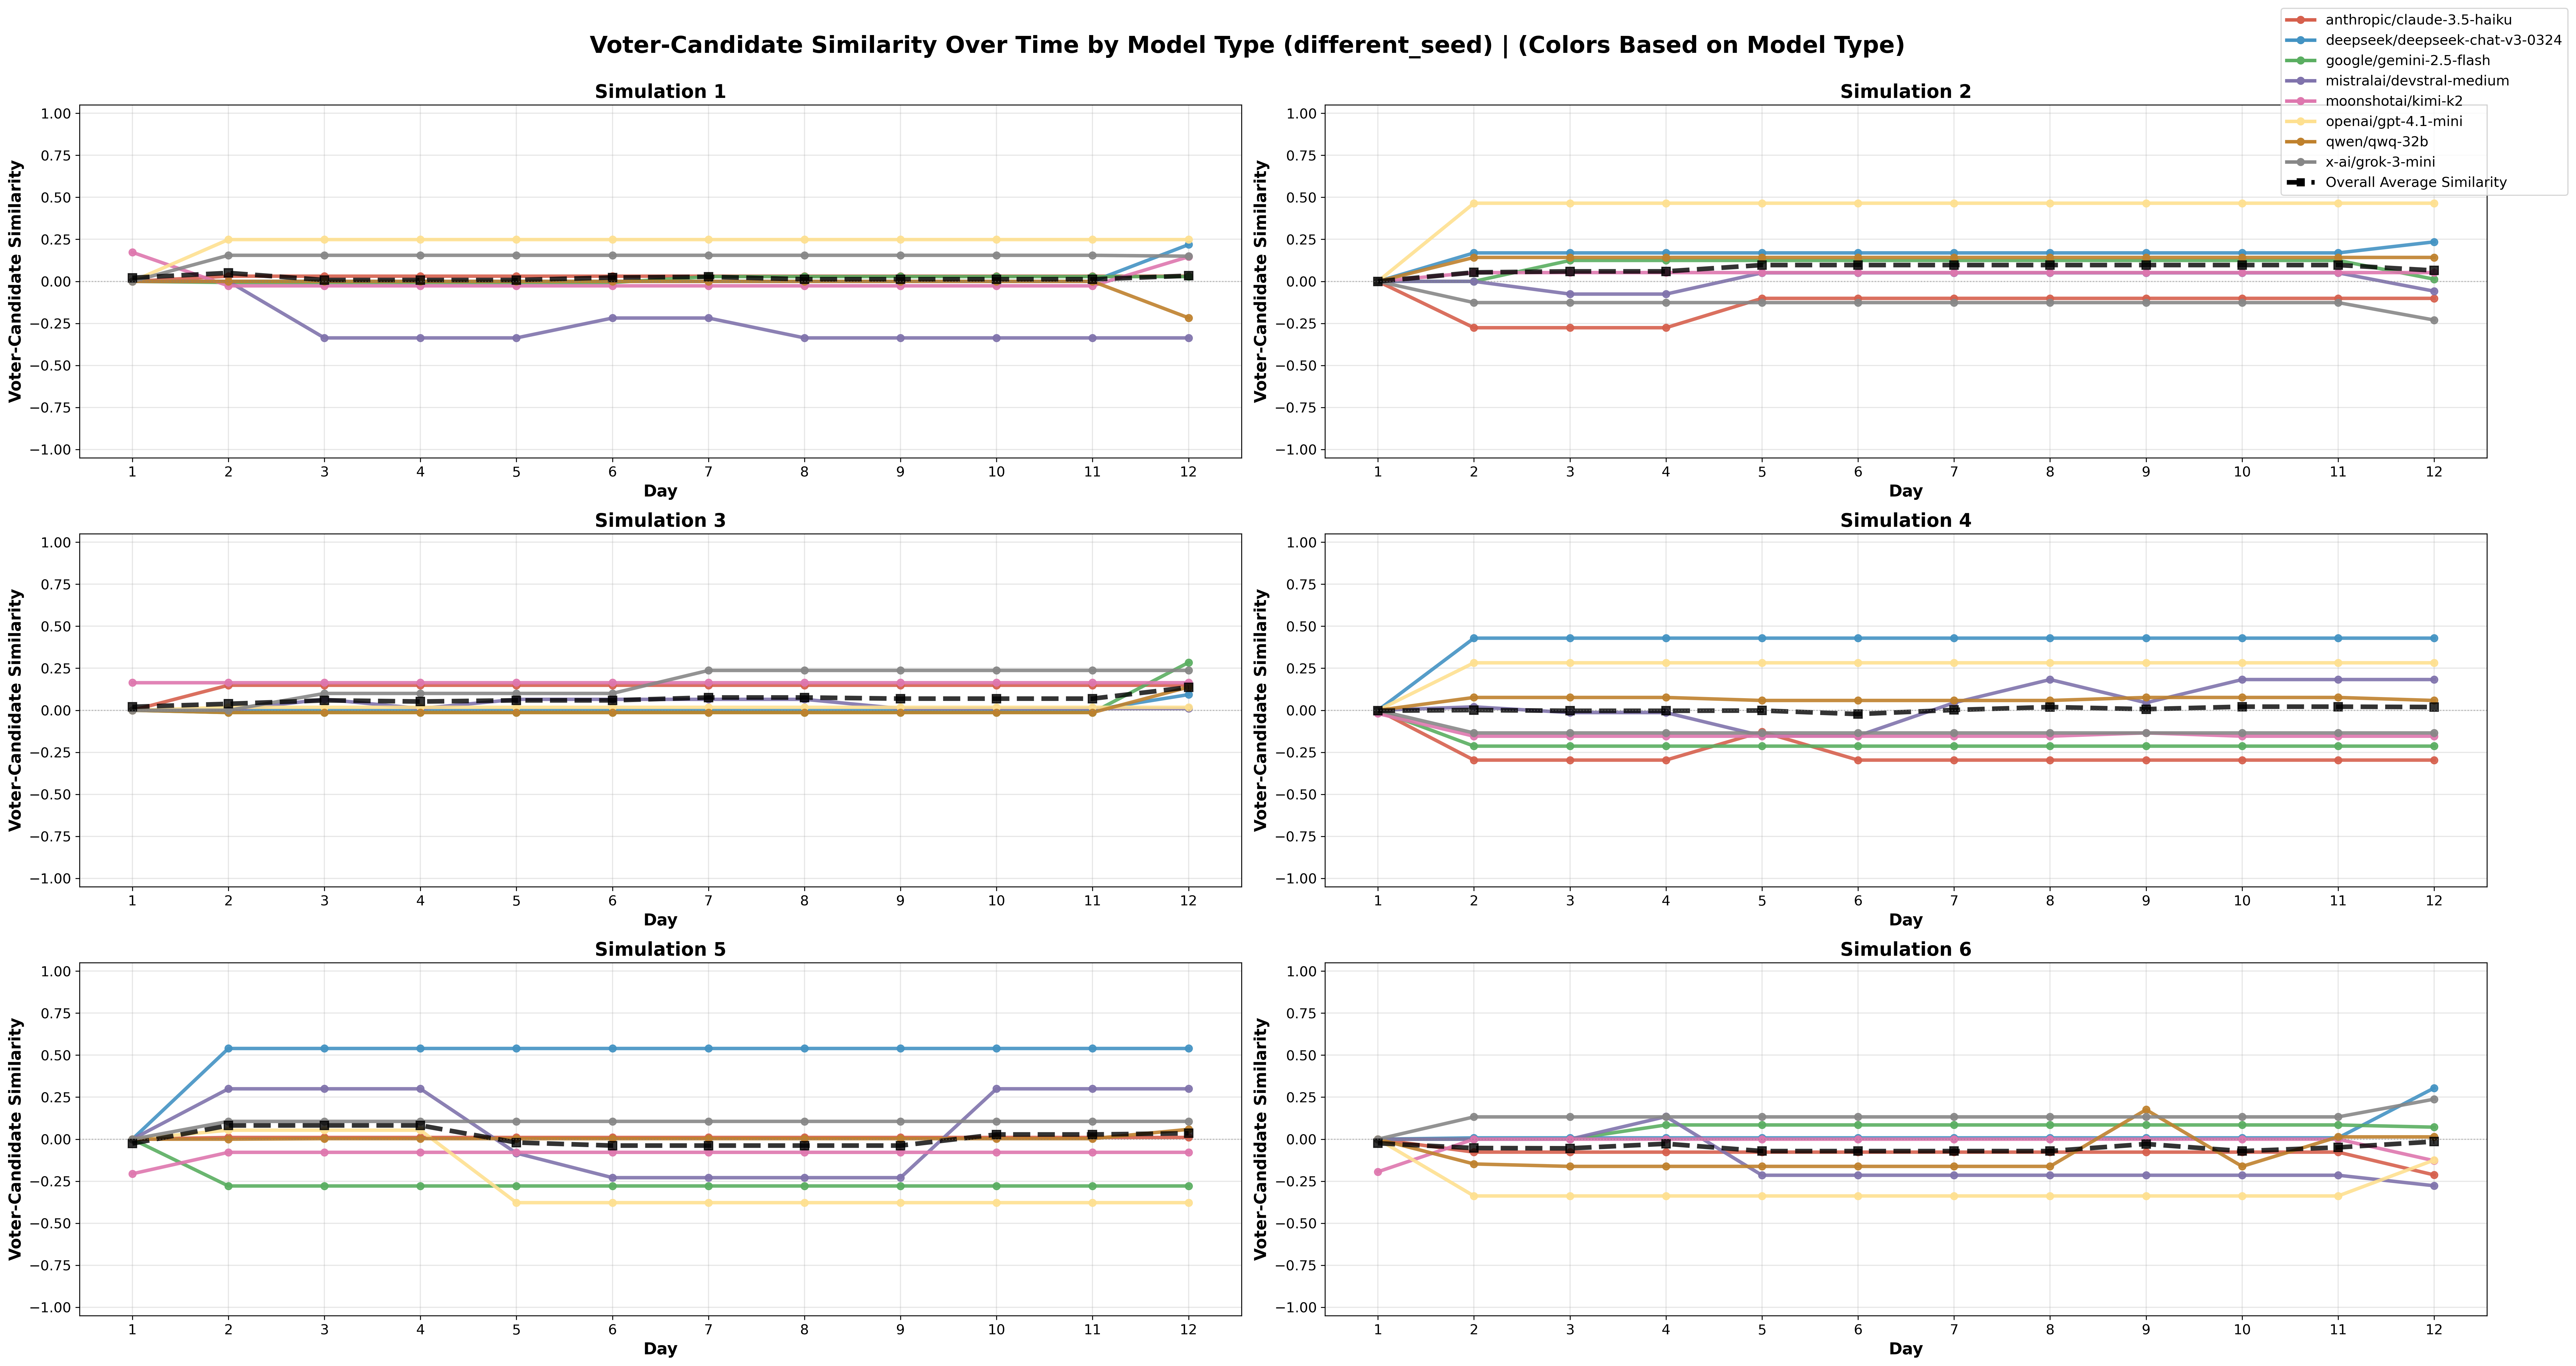

In [55]:
# Plot voter-candidate similarity over time for all simulations
print("Creating combined voter-candidate similarity plots for all simulations...")
plot_all_simulations_voter_candidate_similarity(data, type_data)

In [56]:
def plot_all_simulations_candidate_voter_similarity_with_baseline(
    all_data, type_data=None
):
    """Plot candidate-voter similarity with vote counts for all simulations."""

    num_sims = len(all_data)
    if num_sims == 5:
        rows, cols = 2, 3
        figsize = (24, 16)
    elif num_sims == 6:
        rows, cols = 3, 2
        figsize = (16, 16)
    elif num_sims == 10:
        rows, cols = 2, 5
        figsize = (40, 16)
    else:
        rows, cols = 2, 3
        figsize = (24, 16)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    colors = [
        "#d6604d",
        "#4393c3",
        "#5aae61",
        "#8073ac",
        "#de77ae",
        "#fee090",
        "#bf812d",
        "#878787",
    ]

    all_models = set()
    for sim_data in all_data:
        candidate_agents = get_candidate_agents(sim_data)
        for candidate_profile in candidate_agents.values():
            model_name = candidate_profile.get("model_name", "Unknown")
            all_models.add(model_name)

    sorted_all_models = sorted(all_models)
    model_color_map = {
        model: colors[i % len(colors)] for i, model in enumerate(sorted_all_models)
    }

    for sim_idx, sim_data in enumerate(all_data):
        ax1 = axes[sim_idx]
        ax2 = ax1.twinx()

        history = get_vote_history(sim_data)
        all_agents = get_all_agents(sim_data)
        candidate_agents = get_candidate_agents(sim_data)
        candidate_names = get_candidate_names(sim_data, include_abstain=False)
        voter_agents = get_voter_agents(sim_data)

        num_days = len(history)
        days = list(range(1, num_days + 1))

        candidate_similarities = {name: [] for name in candidate_names}
        candidate_vote_counts = {name: [] for name in candidate_names}

        for day_idx in range(num_days):
            day_votes = history[day_idx]
            day_candidate_sims = {name: [] for name in candidate_names}
            day_vote_counts = {name: 0 for name in candidate_names}

            for voter_name, chosen_candidate in day_votes.items():
                if voter_name in voter_agents and chosen_candidate in candidate_names:
                    day_vote_counts[chosen_candidate] += 1
                    voter_profile = all_agents[voter_name]
                    chosen_candidate_profile = candidate_agents[chosen_candidate]
                    similarity = calculate_similarity(
                        voter_profile, chosen_candidate_profile
                    )
                    day_candidate_sims[chosen_candidate].append(similarity)

            for name in candidate_names:
                candidate_vote_counts[name].append(day_vote_counts[name])

            for name in candidate_names:
                if day_candidate_sims[name]:
                    avg_sim = np.mean(day_candidate_sims[name])
                    candidate_similarities[name].append(avg_sim)
                else:
                    candidate_similarities[name].append(0)

        # similarity lines and vote count lines
        for name in candidate_names:
            candidate_model = candidate_agents[name].get("model_name", "Unknown")

            ax1.plot(
                days,
                candidate_similarities[name],
                marker="o",
                linewidth=3,
                markersize=6,
                label=f"{candidate_model} ({name}) - Similarity",
                color=model_color_map[candidate_model],
                alpha=0.9,
            )

            ax2.plot(
                days,
                candidate_vote_counts[name],
                marker="^",
                linewidth=2,
                markersize=5,
                linestyle="--",
                alpha=0.8,
                color=model_color_map[candidate_model],
                markerfacecolor="white",
                markeredgecolor=model_color_map[candidate_model],
                markeredgewidth=1.5,
            )

        ax1.axhline(y=0, color="gray", linestyle=":", alpha=0.5, linewidth=1)

        ax1.set_xlabel("Day", fontsize=14, fontweight="bold")
        ax1.set_title(f"Simulation {sim_idx + 1}", fontsize=16, fontweight="bold")
        ax1.grid(True, alpha=0.3, linewidth=1)
        ax1.set_ylim(-1.05, 1.05)
        ax1.set_xticks(days)
        ax1.tick_params(axis="both", which="major", labelsize=12)

        max_votes = max(
            [max(counts) for counts in candidate_vote_counts.values()] + [1]
        )
        ax2.set_ylim(0, max_votes * 1.1)
        ax2.tick_params(axis="y", labelcolor="black", labelsize=12)

        if sim_idx % 2 == 0:
            ax1.set_ylabel("Similarity", fontsize=14, fontweight="bold")
        if sim_idx % 2 == 1:
            ax2.set_ylabel("Votes", fontsize=14, fontweight="bold")

    legend_handles = []
    legend_labels = []
    for model_name in sorted_all_models:
        legend_handles.append(
            plt.Line2D([0], [0], color=model_color_map[model_name], lw=3, marker="o")
        )
        legend_labels.append(f"{model_name} - Similarity")
        legend_handles.append(
            plt.Line2D(
                [0],
                [0],
                color=model_color_map[model_name],
                lw=2,
                linestyle="--",
                marker="^",
                markerfacecolor="white",
                markeredgecolor=model_color_map[model_name],
            )
        )
        legend_labels.append(f"{model_name} - Votes")

    fig.legend(
        legend_handles,
        legend_labels,
        bbox_to_anchor=(0.5, 0.01),
        loc="upper center",
        ncol=len(legend_handles) // 2,
        fontsize=10,
    )

    plt.rcParams["figure.dpi"] = 300
    plt.rcParams["savefig.dpi"] = 300
    plt.suptitle(
        f"Average Similarity Between Candidates and Their Voters ({type_data})\n(Colors Based on Model Type)",
        fontsize=20,
        fontweight="bold",
        y=1.0,
    )
    plt.tight_layout()
    plt.show()

Creating combined candidate-voter similarity plots for all simulations...


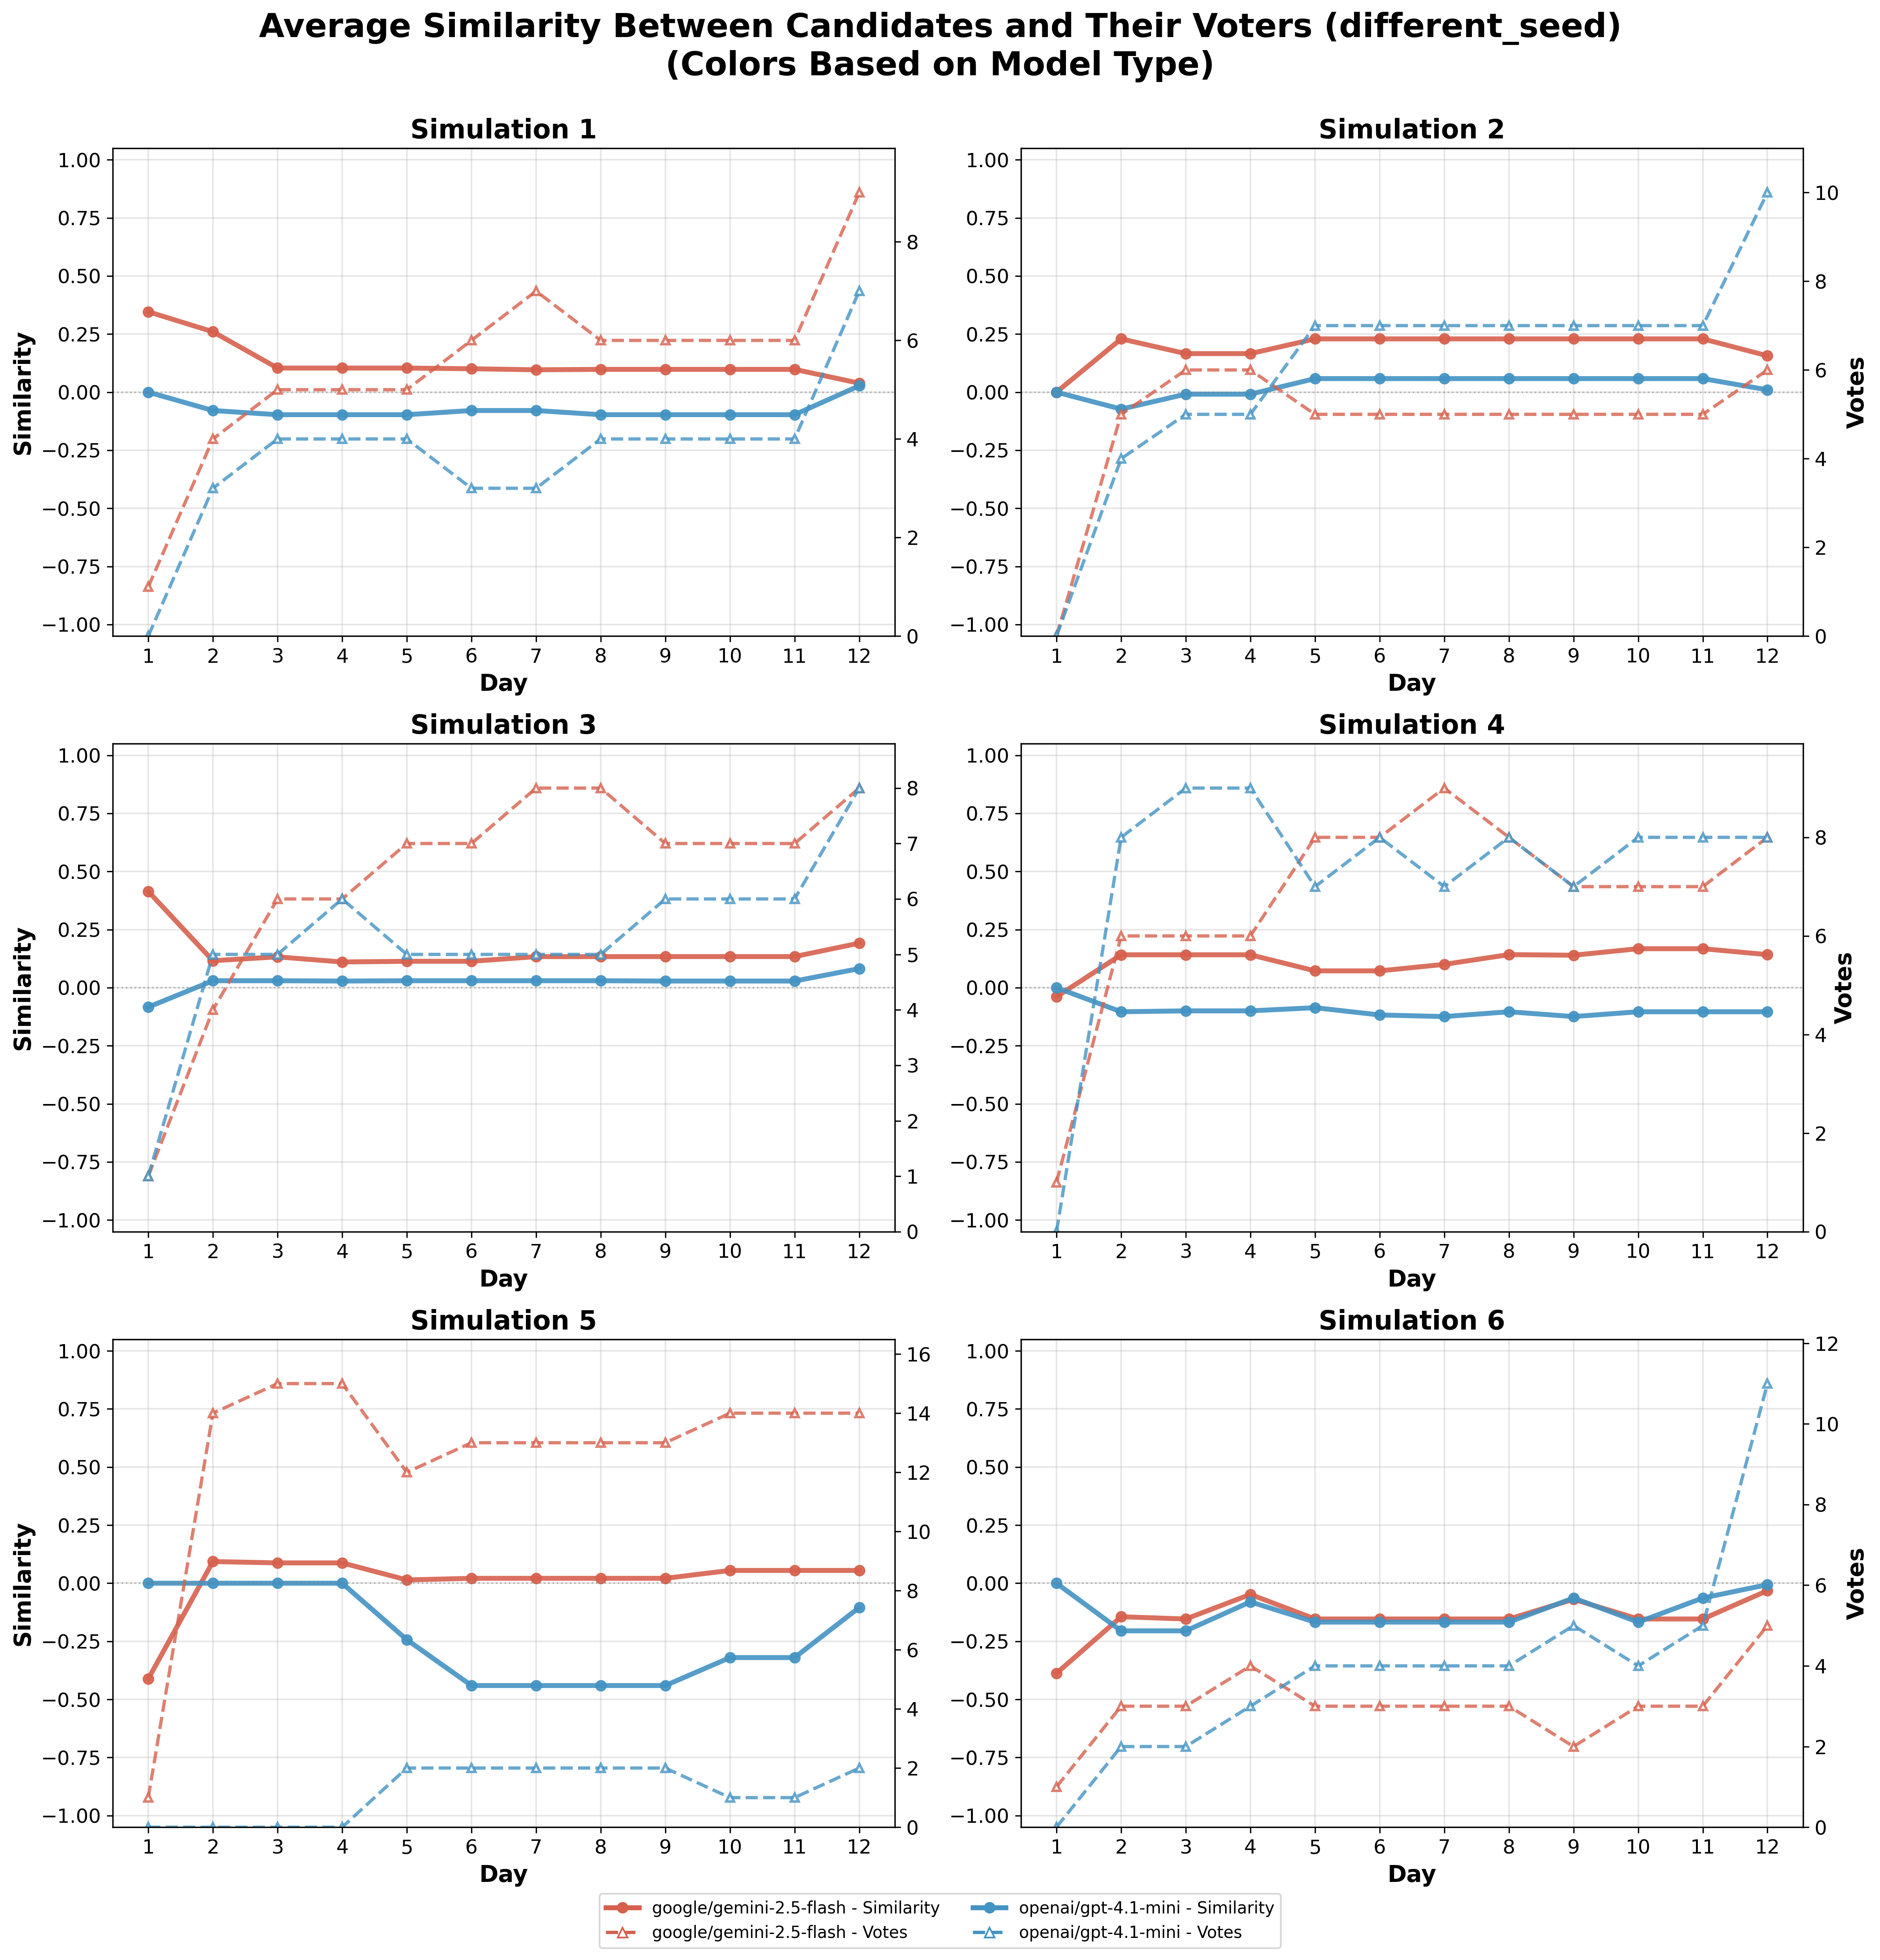

In [57]:
print("Creating combined candidate-voter similarity plots for all simulations...")
plot_all_simulations_candidate_voter_similarity_with_baseline(data, type_data)

In [58]:
def plot_all_simulations_boxplots(all_data, type_data=None):
    """Create box plots showing similarity score distributions for all simulations."""

    num_sims = len(all_data)
    if num_sims == 5:
        rows, cols = 2, 3
        figsize = (24, 16)
    elif num_sims == 6:
        rows, cols = 2, 3
        figsize = (24, 16)
    elif num_sims == 10:
        rows, cols = 2, 5
        figsize = (40, 16)
    else:
        rows, cols = 2, 3
        figsize = (24, 16)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    colors = [
        "#d6604d",
        "#4393c3",
        "#5aae61",
        "#8073ac",
        "#de77ae",
        "#fee090",
        "#bf812d",
        "#878787",
    ]

    # Collect all unique models across all simulations for consistent coloring
    all_models = set()
    for sim_data in all_data:
        candidate_agents = get_candidate_agents(sim_data)
        for candidate_profile in candidate_agents.values():
            model_name = candidate_profile.get("model_name", "Unknown")
            all_models.add(model_name)

    # Create consistent color mapping for all models
    sorted_all_models = sorted(all_models)
    model_color_map = {
        model: colors[i % len(colors)] for i, model in enumerate(sorted_all_models)
    }

    for sim_idx, sim_data in enumerate(all_data):
        ax = axes[sim_idx]

        history = get_vote_history(sim_data)
        all_agents = get_all_agents(sim_data)
        candidate_agents = get_candidate_agents(sim_data)
        candidate_names = get_candidate_names(sim_data, include_abstain=False)
        voter_agents = get_voter_agents(sim_data)

        num_days = len(history)
        plot_data = []

        for day_idx in range(num_days):
            day = day_idx + 1
            day_votes = history[day_idx]

            for candidate_name in candidate_names:
                voter_similarities = []

                for voter_name, chosen_candidate in day_votes.items():
                    if (
                        voter_name in voter_agents
                        and chosen_candidate == candidate_name
                    ):
                        voter_profile = all_agents[voter_name]
                        candidate_profile = candidate_agents[candidate_name]
                        similarity = calculate_similarity(
                            voter_profile, candidate_profile
                        )
                        voter_similarities.append(similarity)

                for similarity in voter_similarities:
                    # Include both candidate name and model for proper ordering
                    candidate_model = candidate_agents[candidate_name].get(
                        "model_name", "Unknown"
                    )
                    # Create a composite label that includes both model and candidate
                    candidate_label = f"{candidate_model} ({candidate_name})"
                    plot_data.append(
                        {
                            "Day": day,
                            "Model": candidate_model,
                            "Candidate": candidate_name,
                            "CandidateLabel": candidate_label,
                            "SimilarityScore": similarity,
                        }
                    )

        df = pd.DataFrame(plot_data)

        if not df.empty:
            # Use consistent color palette based on model types
            # But group by candidate labels for consistent ordering
            palette = {}
            candidate_labels_in_sim = df["CandidateLabel"].unique()

            for label in candidate_labels_in_sim:
                # Extract model name from the first row with this label
                model_name = df[df["CandidateLabel"] == label]["Model"].iloc[0]
                if model_name in model_color_map:
                    palette[label] = model_color_map[model_name]
                else:
                    palette[label] = colors[0]  # fallback color

            # Sort candidate labels by candidate name for consistent ordering
            # This ensures Katie Walker is always left, Jessica Johnson is always right
            sorted_labels = sorted(
                candidate_labels_in_sim,
                key=lambda x: df[df["CandidateLabel"] == x]["Candidate"].iloc[0],
            )

            print(f"Simulation {sim_idx + 1} candidate labels: {sorted_labels}")
            print(df.head())

            sns.boxplot(
                data=df,
                x="Day",
                y="SimilarityScore",
                hue="CandidateLabel",
                hue_order=sorted_labels,
                palette=palette,
                showfliers=True,
                width=0.6,
                ax=ax,
                linewidth=1.5,
            )

        # Add horizontal line at y=0
        ax.axhline(y=0, color="gray", linestyle=":", alpha=0.5, linewidth=1)

        # Set the title for each subplot to show the two models used in this simulation
        models_in_sim = set(df["Model"].unique()) if not df.empty else set()
        models_str = " vs. ".join(sorted(models_in_sim))
        ax.set_title(models_str, fontsize=16, fontweight="bold")
        ax.set_xlabel("Day", fontsize=14, fontweight="bold")
        ax.set_ylabel("Similarity Score", fontsize=14, fontweight="bold")
        ax.set_ylim(-1.05, 1.05)
        ax.grid(True, alpha=0.3, axis="y", linewidth=1)
        ax.tick_params(axis="both", which="major", labelsize=12)

        if ax.get_legend():
            ax.get_legend().remove()

    legend_handles = []
    legend_labels = []
    for model_name in sorted_all_models:
        legend_handles.append(
            plt.Rectangle((0, 0), 1, 1, facecolor=model_color_map[model_name])
        )
        legend_labels.append(model_name)

    fig.legend(
        legend_handles,
        legend_labels,
        title="Model",
        bbox_to_anchor=(0.89, 1.0),
        loc="center left",
        fontsize=10,
        title_fontsize=12,
    )

    if all_data:
        first_sim_data = all_data[0]
        candidate_names_for_title = get_candidate_names(
            first_sim_data, include_abstain=False
        )
        if len(candidate_names_for_title) >= 2:
            left_candidate = candidate_names_for_title[0]
            right_candidate = candidate_names_for_title[-1]
            title_suffix = f"\n(Left: {left_candidate}   |   Right: {right_candidate})"
        else:
            title_suffix = ""
    else:
        title_suffix = ""

    plt.suptitle(
        f"Distribution of Voter-Candidate Similarity Scores Over Time ({type_data})\n(Colors Based on Model Type)"
        + title_suffix,
        fontsize=20,
        fontweight="bold",
        y=1.0,
    )
    plt.tight_layout()
    plt.show()

Creating combined box plots for all simulations...
Simulation 1 candidate labels: ['openai/gpt-4.1-mini (Jessica Johnson)', 'google/gemini-2.5-flash (Katie Walker)']
   Day                    Model     Candidate  \
0    1  google/gemini-2.5-flash  Katie Walker   
1    2  google/gemini-2.5-flash  Katie Walker   
2    2  google/gemini-2.5-flash  Katie Walker   
3    2  google/gemini-2.5-flash  Katie Walker   
4    2  google/gemini-2.5-flash  Katie Walker   

                           CandidateLabel  SimilarityScore  
0  google/gemini-2.5-flash (Katie Walker)         0.346031  
1  google/gemini-2.5-flash (Katie Walker)         0.275222  
2  google/gemini-2.5-flash (Katie Walker)         0.222052  
3  google/gemini-2.5-flash (Katie Walker)         0.232559  
4  google/gemini-2.5-flash (Katie Walker)         0.310240  
Simulation 2 candidate labels: ['google/gemini-2.5-flash (Casey Harvey)', 'openai/gpt-4.1-mini (Christine Riley)']
   Day                    Model     Candidate  \
0    2  g

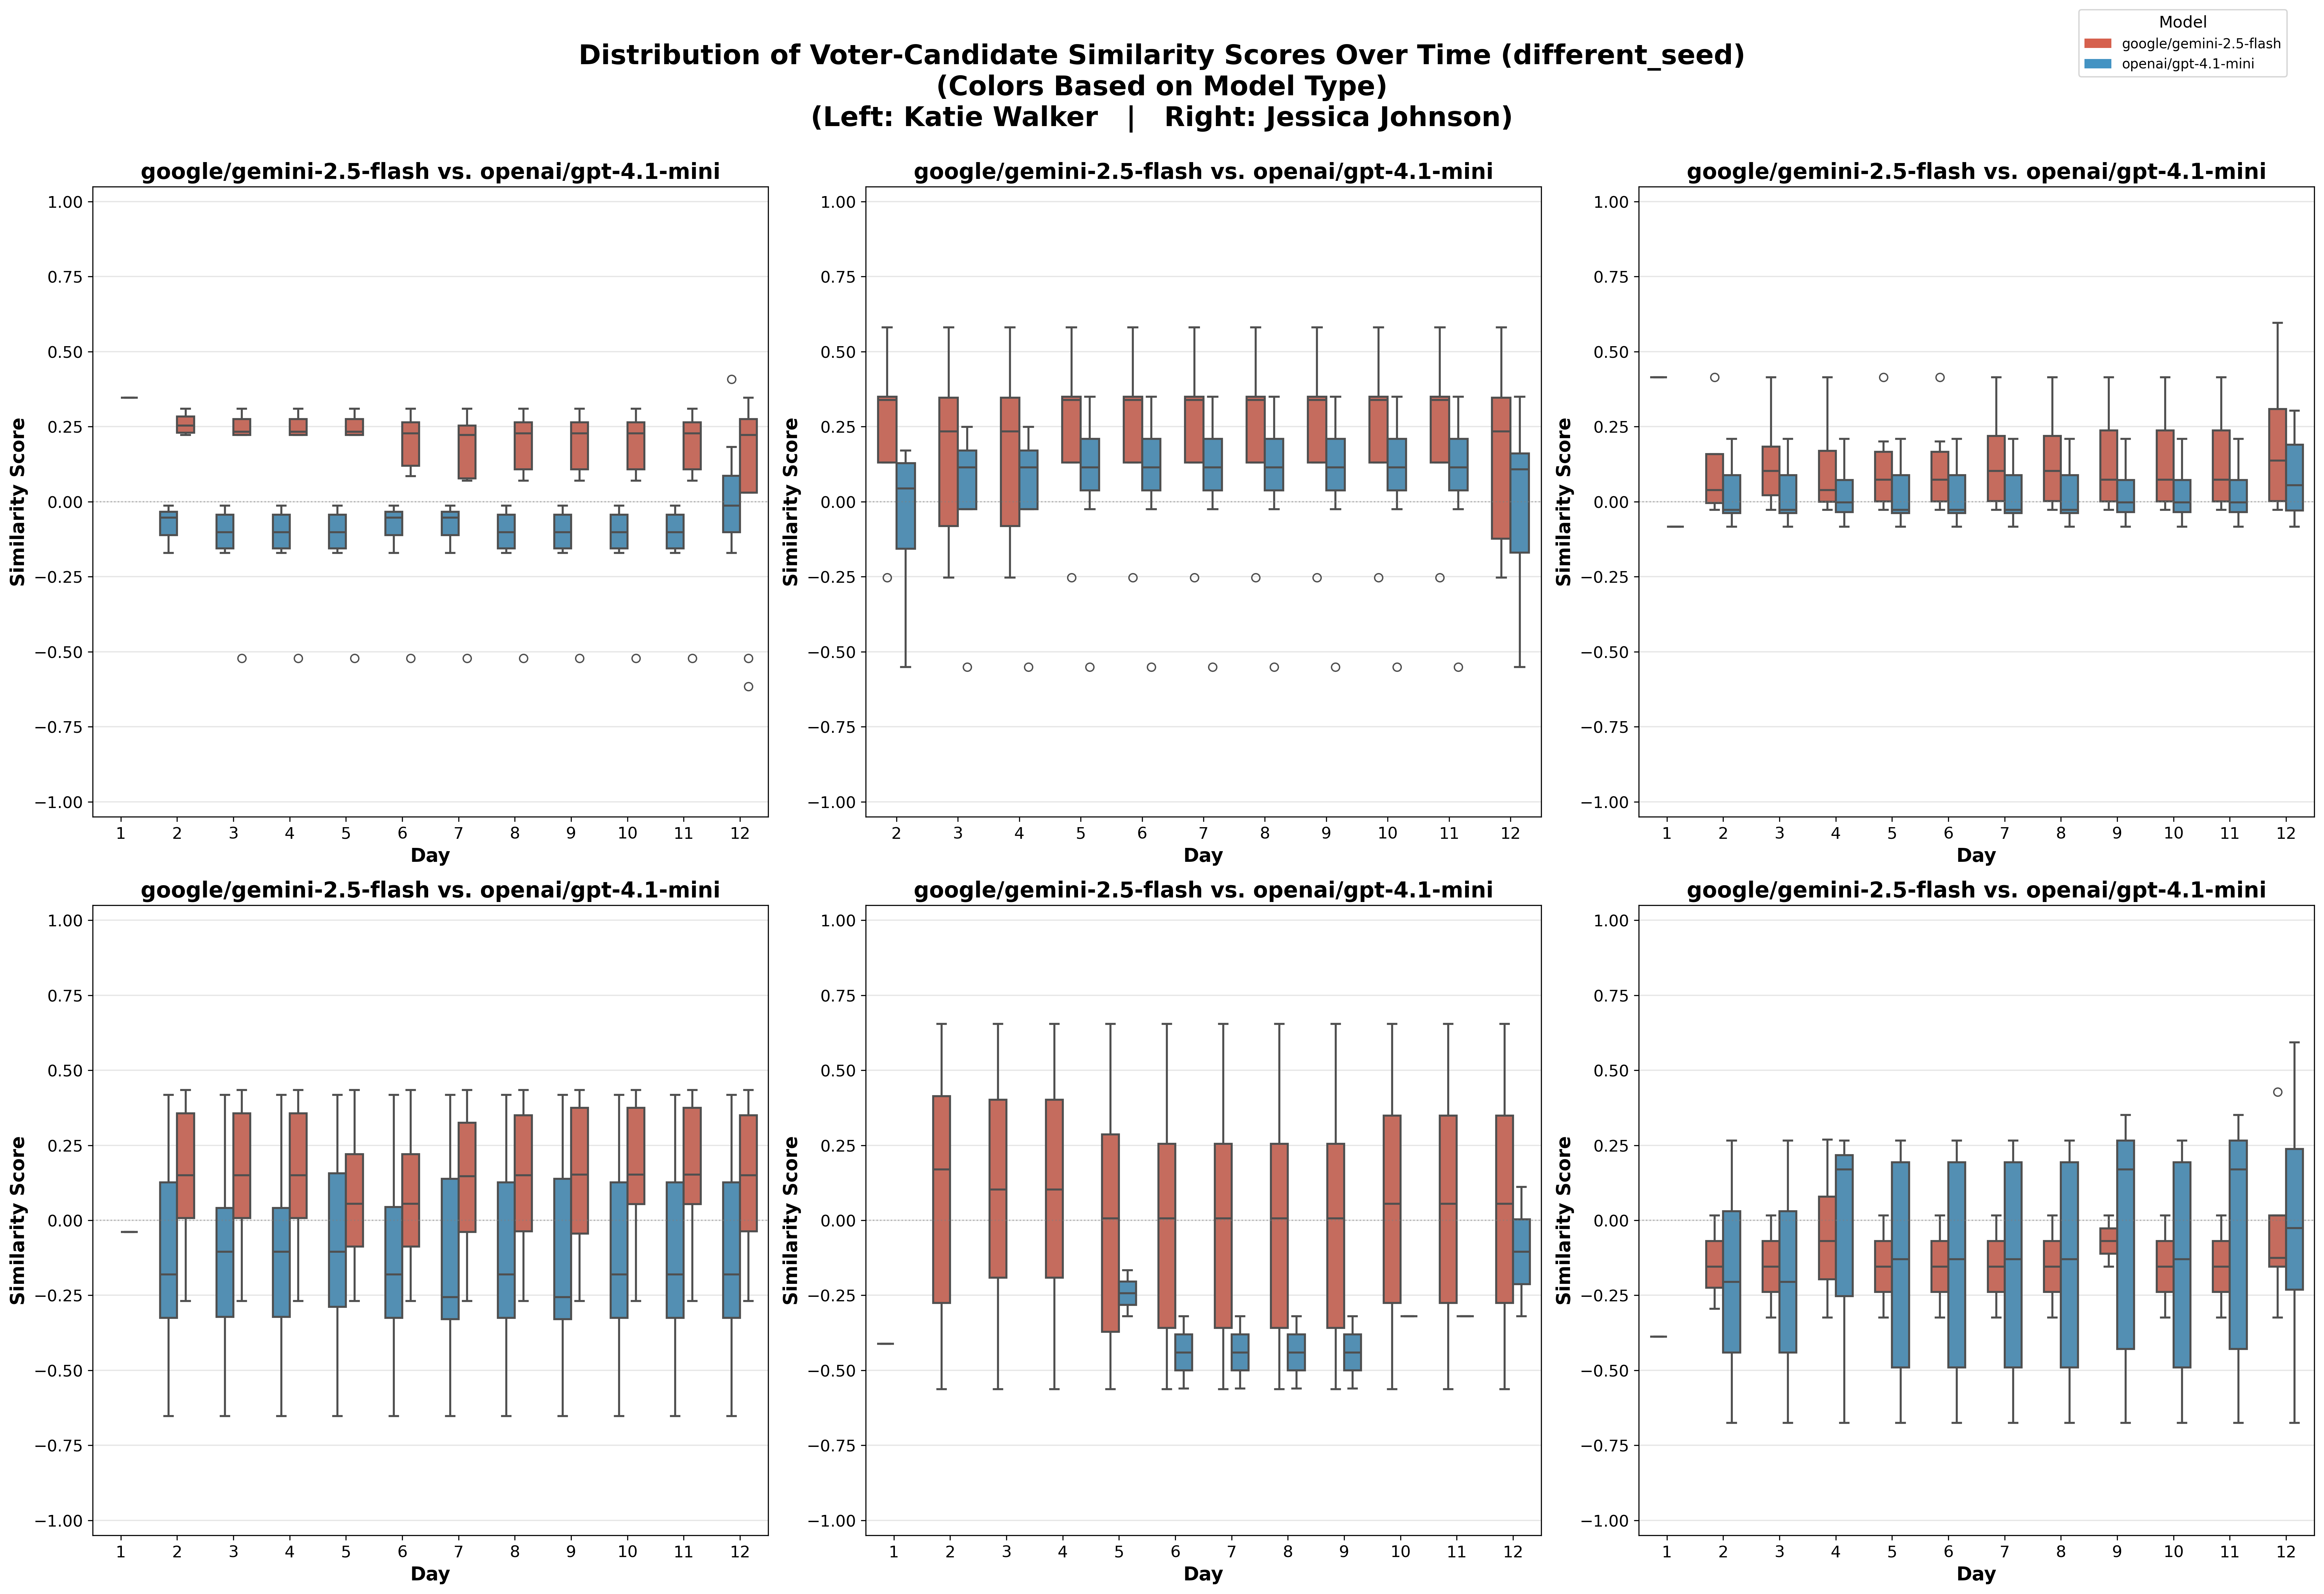

In [59]:
# Create box plots showing similarity score distributions for all simulations
print("Creating combined box plots for all simulations...")
plot_all_simulations_boxplots(data, type_data)

In [60]:
def plot_combined_model_candidate_similarity(all_data, type_data=None):
    """Plot average similarity between each model and the candidates they chose across all simulations."""

    colors = [
        "#d6604d",
        "#4393c3",
        "#5aae61",
        "#8073ac",
        "#de77ae",
        "#fee090",
        "#bf812d",
        "#878787",
    ]

    all_models = set()
    for sim_data in all_data:
        voter_agents = get_voter_agents(sim_data)
        for voter_profile in voter_agents.values():
            model_name = voter_profile.get("model_name", "Unknown")
            all_models.add(model_name)

    sorted_models = sorted(all_models)
    model_color_map = {
        model: colors[i % len(colors)] for i, model in enumerate(sorted_models)
    }

    all_model_similarities = {model: [] for model in sorted_models}
    max_days = 0

    for sim_data in all_data:
        history = get_vote_history(sim_data)
        voter_agents = get_voter_agents(sim_data)
        candidate_agents = get_candidate_agents(sim_data)

        num_days = len(history)
        max_days = max(max_days, num_days)

        model_voters = {}
        for voter_name, voter_profile in voter_agents.items():
            model_name = voter_profile.get("model_name", "Unknown")
            if model_name not in model_voters:
                model_voters[model_name] = []
            model_voters[model_name].append(voter_name)

        for model_name in sorted_models:
            if model_name not in model_voters:
                all_model_similarities[model_name].extend([0] * num_days)
                continue

            voters_in_model = model_voters[model_name]
            model_daily_similarities = []

            for day_idx in range(num_days):
                day_votes = history[day_idx]
                day_similarities = []

                for voter_name in voters_in_model:
                    if voter_name in day_votes:
                        chosen_candidate = day_votes[voter_name]

                        if (
                            chosen_candidate == "ABSTAIN"
                            or chosen_candidate not in candidate_agents
                        ):
                            similarity = 0
                        else:
                            voter_profile = voter_agents[voter_name]
                            candidate_profile = candidate_agents[chosen_candidate]
                            similarity = calculate_similarity(
                                voter_profile, candidate_profile
                            )
                    else:
                        similarity = 0

                    day_similarities.append(similarity)

                model_daily_similarities.append(
                    np.mean(day_similarities) if day_similarities else 0
                )

            all_model_similarities[model_name].extend(model_daily_similarities)

    days = list(range(1, max_days + 1))

    plt.figure(figsize=(16, 8))

    for model_name in sorted_models:
        similarities = all_model_similarities[model_name]

        if len(similarities) > 0:
            sim_array = np.array(similarities).reshape(-1, max_days)
            avg_similarities = np.mean(sim_array, axis=0)

            plt.plot(
                days,
                avg_similarities,
                marker="o",
                linewidth=3,
                markersize=7,
                label=model_name,
                alpha=0.9,
                color=model_color_map[model_name],
            )

    overall_similarities = []
    for day_idx in range(max_days):
        day_values = []
        for model_name in sorted_models:
            similarities = all_model_similarities[model_name]
            if len(similarities) > 0:
                sim_array = np.array(similarities).reshape(-1, max_days)
                day_values.append(np.mean(sim_array[:, day_idx]))
        overall_similarities.append(np.mean(day_values) if day_values else 0)

    plt.plot(
        days,
        overall_similarities,
        color="black",
        linewidth=4,
        label="Overall Average",
        linestyle="--",
        marker="s",
        markersize=8,
        alpha=0.8,
    )

    plt.axhline(y=0, color="gray", linestyle=":", alpha=0.7, linewidth=2)

    plt.xlabel("Day", fontsize=16, fontweight="bold")
    plt.ylabel("Model-Candidate Similarity", fontsize=16, fontweight="bold")
    plt.title(
        f"Average Model-Candidate Similarity Over Time ({type_data})",
        fontsize=18,
        fontweight="bold",
        pad=20,
    )
    plt.grid(True, alpha=0.3, linewidth=1)
    plt.legend(bbox_to_anchor=(1.0, 1.01), loc="upper left", fontsize=12)
    plt.ylim(-1.05, 1.05)
    plt.xticks(days, fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

    return all_model_similarities, overall_similarities

Creating combined model-candidate similarity chart...


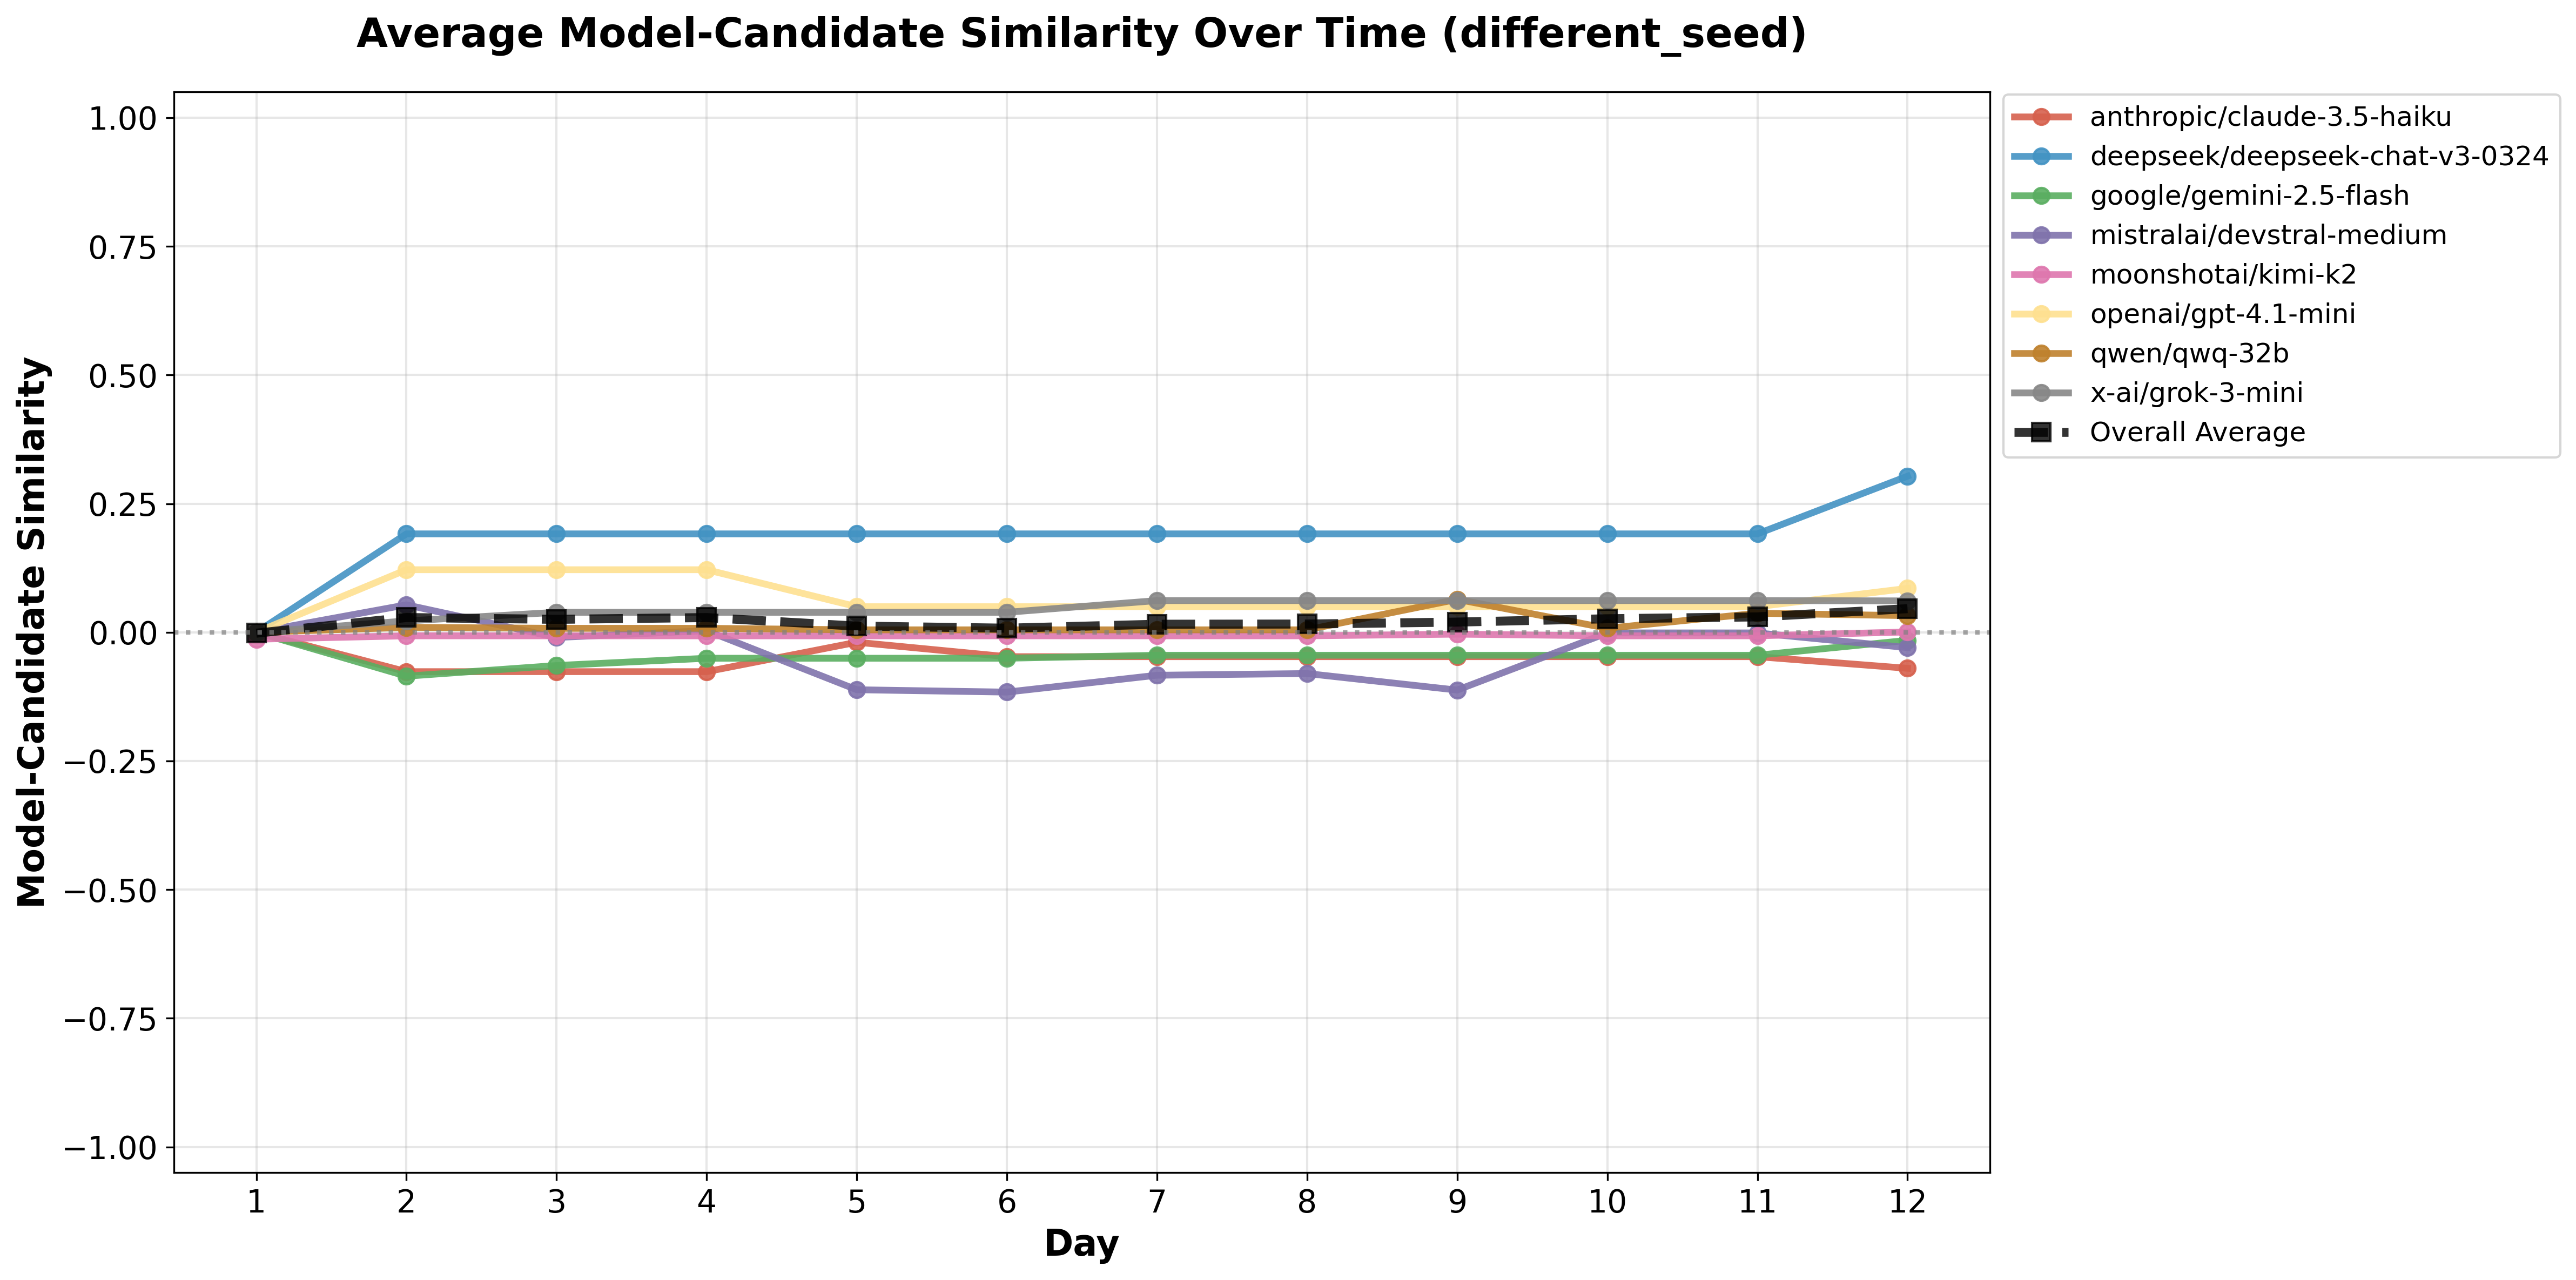


Average similarity by model across all simulations:
anthropic/claude-3.5-haiku: -0.050
deepseek/deepseek-chat-v3-0324: 0.185
google/gemini-2.5-flash: -0.045
mistralai/devstral-medium: -0.041
moonshotai/kimi-k2: -0.007
openai/gpt-4.1-mini: 0.067
qwen/qwq-32b: 0.015
x-ai/grok-3-mini: 0.046

Overall average similarity across all days: 0.021


In [61]:
print("Creating combined model-candidate similarity chart...")
model_similarities, overall_avg = plot_combined_model_candidate_similarity(
    data, type_data
)

print("\nAverage similarity by model across all simulations:")
for model_name, similarities in model_similarities.items():
    if len(similarities) > 0:
        avg_similarity = np.mean(similarities)
        print(f"{model_name}: {avg_similarity:.3f}")

print(f"\nOverall average similarity across all days: {np.mean(overall_avg):.3f}")

In [62]:
def plot_consolidated_model_similarity_boxplot(all_data, type_data=None):
    """Create consolidated box plot showing candidate-voter similarity distributions by day across all simulations."""

    colors = [
        "#d6604d",
        "#4393c3",
        "#5aae61",
        "#8073ac",
        "#de77ae",
        "#fee090",
        "#bf812d",
        "#878787",
    ]

    all_models = set()
    for sim_data in all_data:
        candidate_agents = get_candidate_agents(sim_data)
        for candidate_profile in candidate_agents.values():
            model_name = candidate_profile.get("model_name", "Unknown")
            all_models.add(model_name)

    sorted_models = sorted(all_models)
    model_color_map = {
        model: colors[i % len(colors)] for i, model in enumerate(sorted_models)
    }

    plot_data = []
    max_days = 0

    for sim_data in all_data:
        history = get_vote_history(sim_data)
        all_agents = get_all_agents(sim_data)
        candidate_agents = get_candidate_agents(sim_data)
        candidate_names = get_candidate_names(sim_data, include_abstain=False)
        voter_agents = get_voter_agents(sim_data)

        num_days = len(history)
        max_days = max(max_days, num_days)

        for day_idx in range(num_days):
            day = day_idx + 1
            day_votes = history[day_idx]

            for candidate_name in candidate_names:
                candidate_model = candidate_agents[candidate_name].get(
                    "model_name", "Unknown"
                )

                for voter_name, chosen_candidate in day_votes.items():
                    if (
                        voter_name in voter_agents
                        and chosen_candidate == candidate_name
                    ):
                        voter_profile = all_agents[voter_name]
                        candidate_profile = candidate_agents[candidate_name]
                        similarity = calculate_similarity(
                            voter_profile, candidate_profile
                        )

                        plot_data.append(
                            {
                                "Day": day,
                                "Model": candidate_model,
                                "SimilarityScore": similarity,
                            }
                        )

    df = pd.DataFrame(plot_data)

    plt.figure(figsize=(16, 10))

    ax = sns.boxplot(
        data=df,
        x="Day",
        y="SimilarityScore",
        hue="Model",
        palette=model_color_map,
        showfliers=True,
        width=0.7,
        linewidth=2,
    )

    plt.axhline(y=0, color="gray", linestyle=":", alpha=0.7, linewidth=2)

    plt.title(
        f"Distribution of Candidate-Voter Similarity Scores Over Time ({type_data})\n(Colors Based on Candidate Model Type)",
        fontsize=18,
        fontweight="bold",
        pad=20,
    )
    plt.xlabel("Day", fontsize=16, fontweight="bold")
    plt.ylabel("Candidate-Voter Similarity Score", fontsize=16, fontweight="bold")
    plt.ylim(-1.05, 1.05)

    plt.legend(
        title="Model",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=12,
        title_fontsize=14,
        framealpha=0.9,
    )

    plt.grid(True, alpha=0.3, axis="y", linewidth=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if max_days > 10:
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("Summary Statistics by Day and Candidate Model:")
    print("=" * 50)

    for day in sorted(df["Day"].unique()):
        print(f"\nDay {day}:")
        day_data = df[df["Day"] == day]

        for model in sorted_models:
            model_data = day_data[day_data["Model"] == model]["SimilarityScore"]

            if len(model_data) > 0:
                print(f"  {model}:")
                print(f"    Count: {len(model_data)}")
                print(f"    Mean: {model_data.mean():.3f}")
                print(f"    Median: {model_data.median():.3f}")
                print(f"    Std Dev: {model_data.std():.3f}")
                print(f"    Min: {model_data.min():.3f}")
                print(f"    Max: {model_data.max():.3f}")
            else:
                print(f"  {model}: No data")

    return df

Creating consolidated candidate-voter similarity box plot...


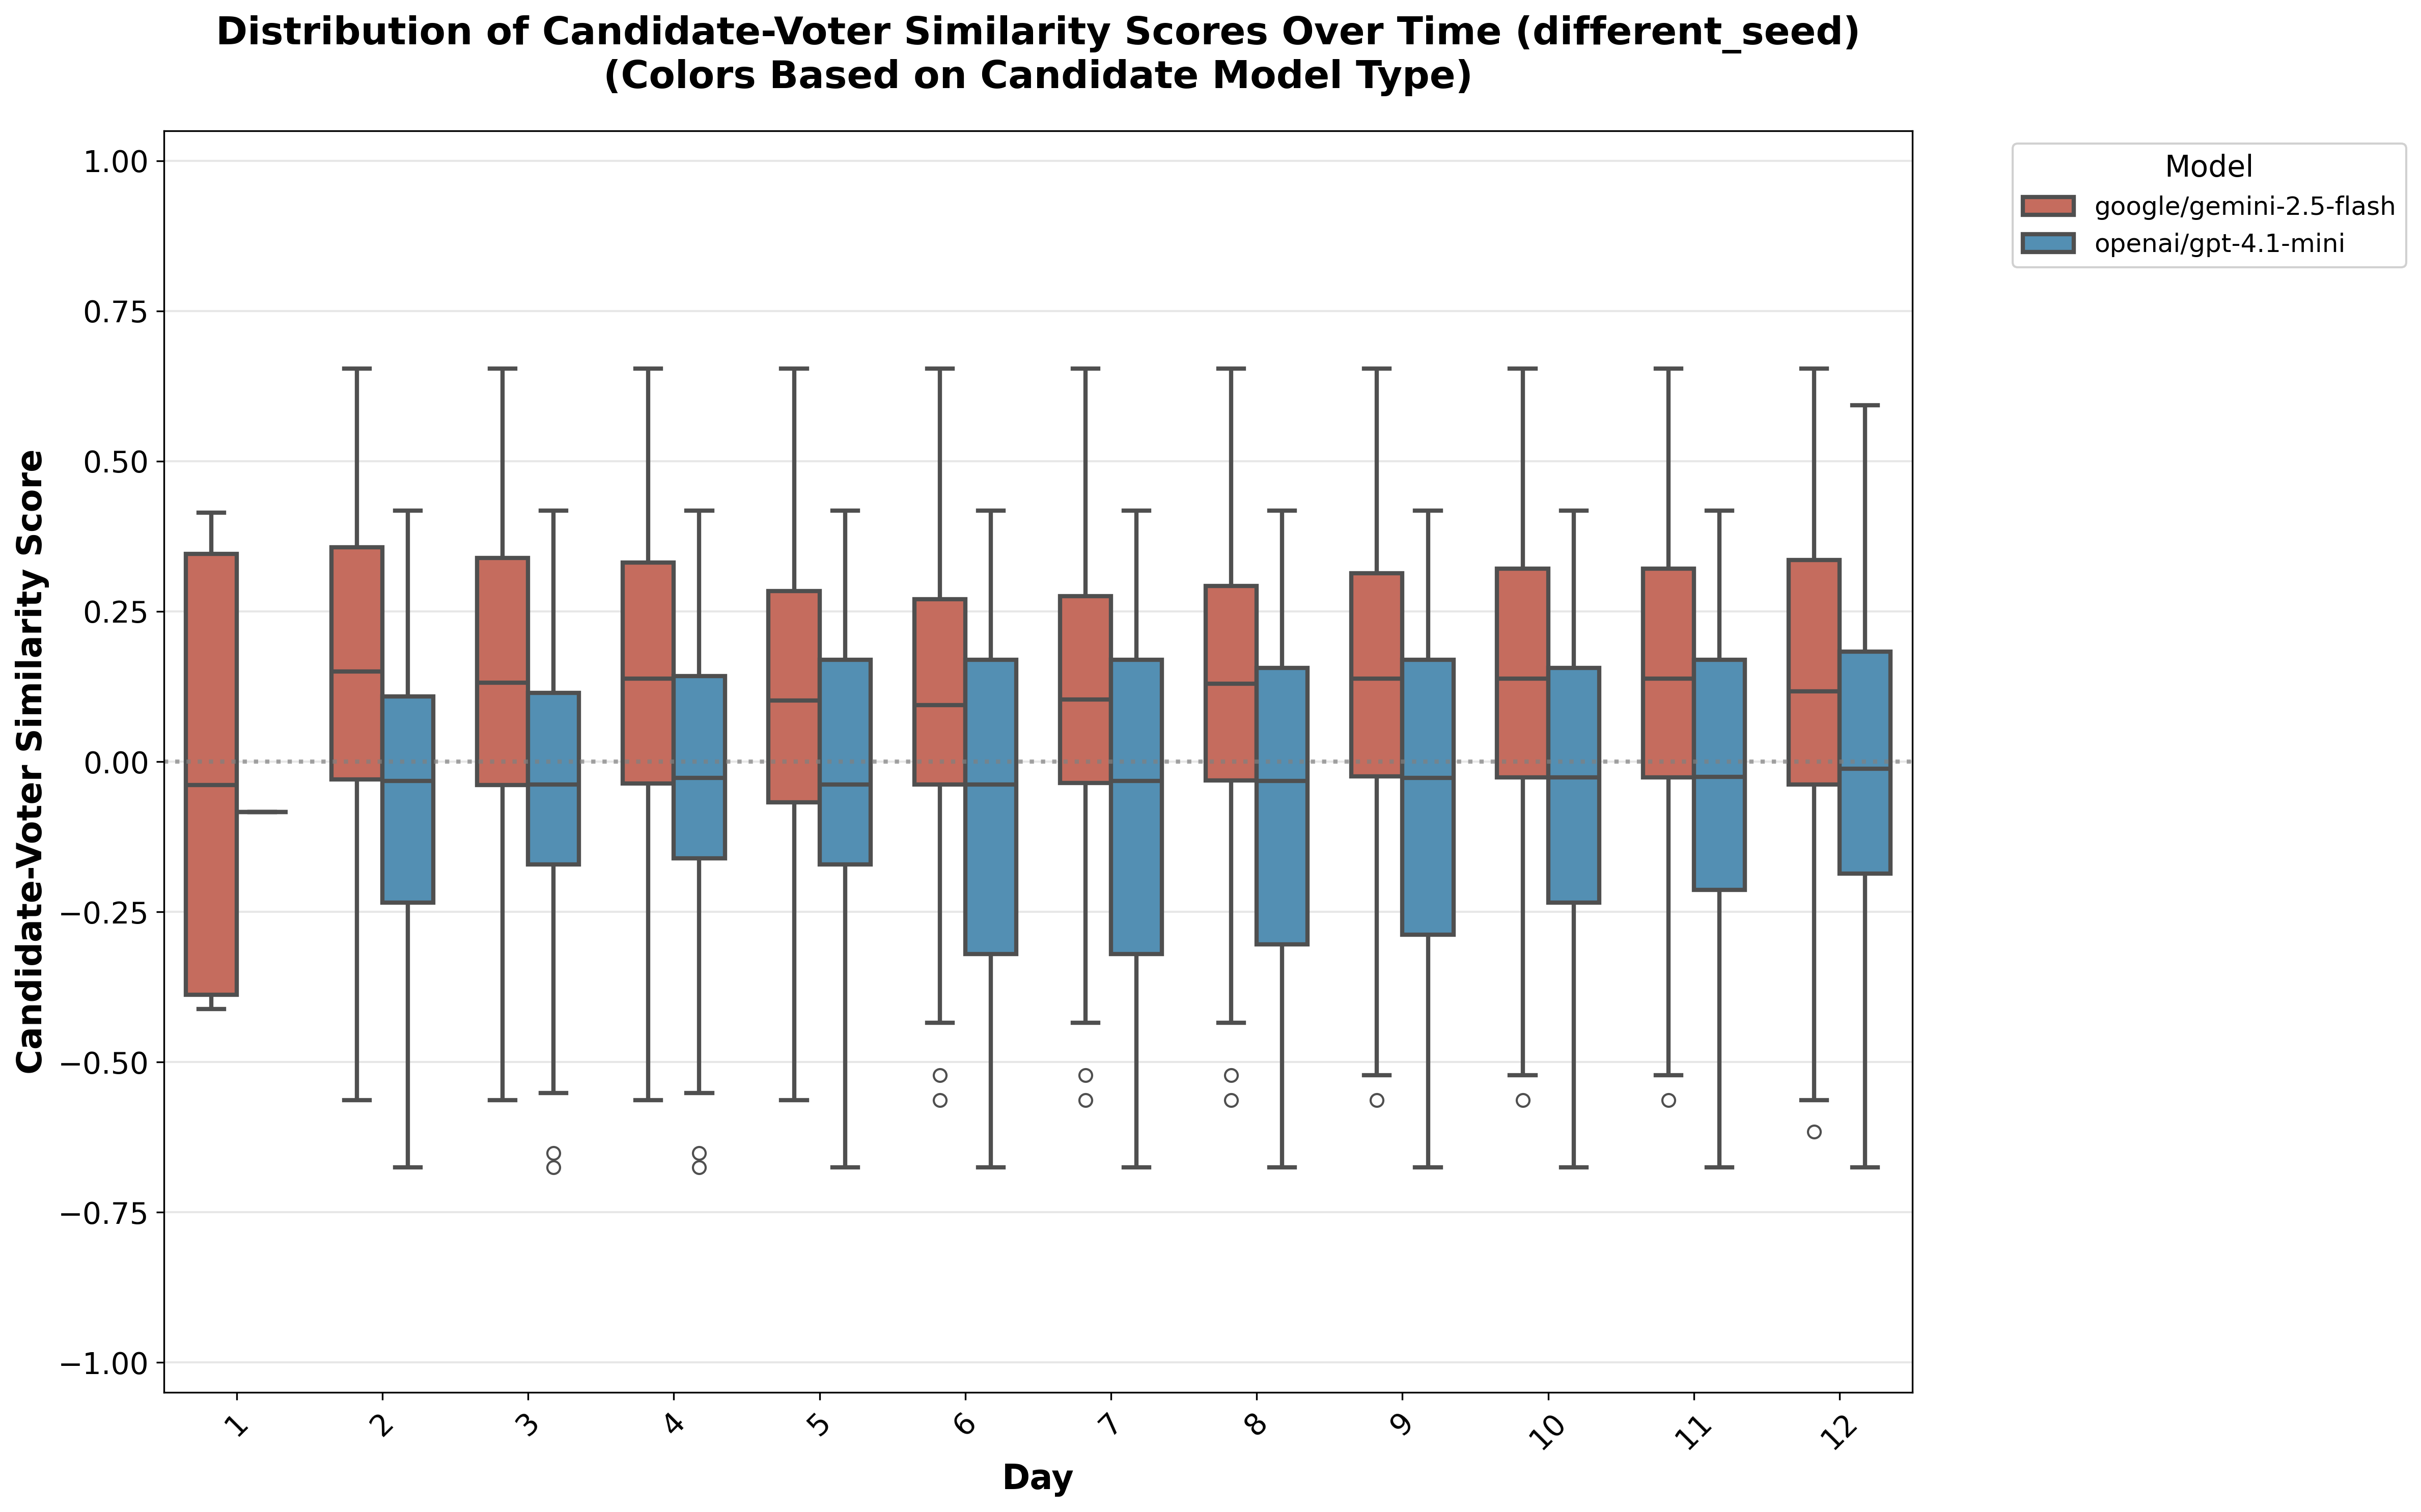

Summary Statistics by Day and Candidate Model:

Day 1:
  google/gemini-2.5-flash:
    Count: 5
    Mean: -0.016
    Median: -0.039
    Std Dev: 0.391
    Min: -0.411
    Max: 0.414
  openai/gpt-4.1-mini:
    Count: 1
    Mean: -0.084
    Median: -0.084
    Std Dev: nan
    Min: -0.084
    Max: -0.084

Day 2:
  google/gemini-2.5-flash:
    Count: 36
    Mean: 0.121
    Median: 0.150
    Std Dev: 0.312
    Min: -0.563
    Max: 0.654
  openai/gpt-4.1-mini:
    Count: 22
    Mean: -0.074
    Median: -0.032
    Std Dev: 0.300
    Min: -0.675
    Max: 0.418

Day 3:
  google/gemini-2.5-flash:
    Count: 41
    Mean: 0.098
    Median: 0.131
    Std Dev: 0.313
    Min: -0.563
    Max: 0.654
  openai/gpt-4.1-mini:
    Count: 25
    Mean: -0.064
    Median: -0.038
    Std Dev: 0.288
    Min: -0.675
    Max: 0.418

Day 4:
  google/gemini-2.5-flash:
    Count: 42
    Mean: 0.099
    Median: 0.138
    Std Dev: 0.310
    Min: -0.563
    Max: 0.654
  openai/gpt-4.1-mini:
    Count: 27
    Mean: -0.052

In [63]:
print("Creating consolidated candidate-voter similarity box plot...")
consolidated_df = plot_consolidated_model_similarity_boxplot(data, type_data)

print(f"\nTotal data points: {len(consolidated_df)}")
print(f"Candidate models analyzed: {sorted(consolidated_df['Model'].unique())}")
print(f"Days covered: {sorted(consolidated_df['Day'].unique())}")

overall_stats = consolidated_df.groupby("Model")["SimilarityScore"].agg(
    ["mean", "std", "count"]
)
print(f"\nOverall statistics by candidate model:")
print(overall_stats.round(3))